## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

## Cleaning Corrected Data

In [3]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [4]:
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [5]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [6]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [8]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [9]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

# FEATURE ENGINEERING

## DATA SCIENTIST SKILLS

### programming languages - python, r
### data analysis - pandas, numpy
### visualisation - tableau, matplotlib, seaborn, powerbi
### dbms - sql
### modeling - machine learning, deep learning, scikit-learn, regression, classification
### statistics

## Creating flags for all the skills

In [10]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

In [11]:
df_train['Programming_Language_Flag'] = np.where(df_train['tags'].str.contains('python|r'),1,0)
df_train['Data_Analysis_Flag'] = np.where(df_train['tags'].str.contains('pandas|exploratory-data-analysis|dataframe|data-analysis'),1,0)
df_train['DBMS_Flag'] = np.where(df_train['tags'].str.contains('sql'),1,0)
df_train['Visualization_Flag'] = np.where(df_train['tags'].str.contains('tableau|powerbi|power-bi|seaborn|matplotlib|visualization|ggplot'),1,0)
df_train['Modeling_Flag'] = np.where(df_train['tags'].str.contains('scikit-learn|statsmodels|machine-learning|regression'),1,0)
df_train['Data_Analysis_Flag'] = np.where(df_train['Modeling_Flag']==1, 1, df_train['Data_Analysis_Flag'])
df_train['Statistics_Flag'] = np.where(df_train['tags'].str.contains('statistics|scipy|anova|hypothesis|statistical|anova'),1,0)
df_train['total_requirements_satisfied'] = df_train['Programming_Language_Flag']+df_train['DBMS_Flag']+df_train['Visualization_Flag']+df_train['Modeling_Flag']+df_train['Data_Analysis_Flag']+ df_train['Statistics_Flag']

## Shortlisting Data Scientists

In [12]:
df_train = df_train[df_train['total_requirements_satisfied']>=2]

In [13]:
df_train.shape

(5600, 23)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 17.165866
                  Log  0.053610
           Reciprocal  2.099949
Exponential power 0.2  1.200539
Exponential power 0.3  2.051109
          Square Root  4.510561
            Cube Root  2.380105
               Boxcox  0.006343

 Best Transformation for  reputation : 
 Boxcox = 0.0063429840059436365


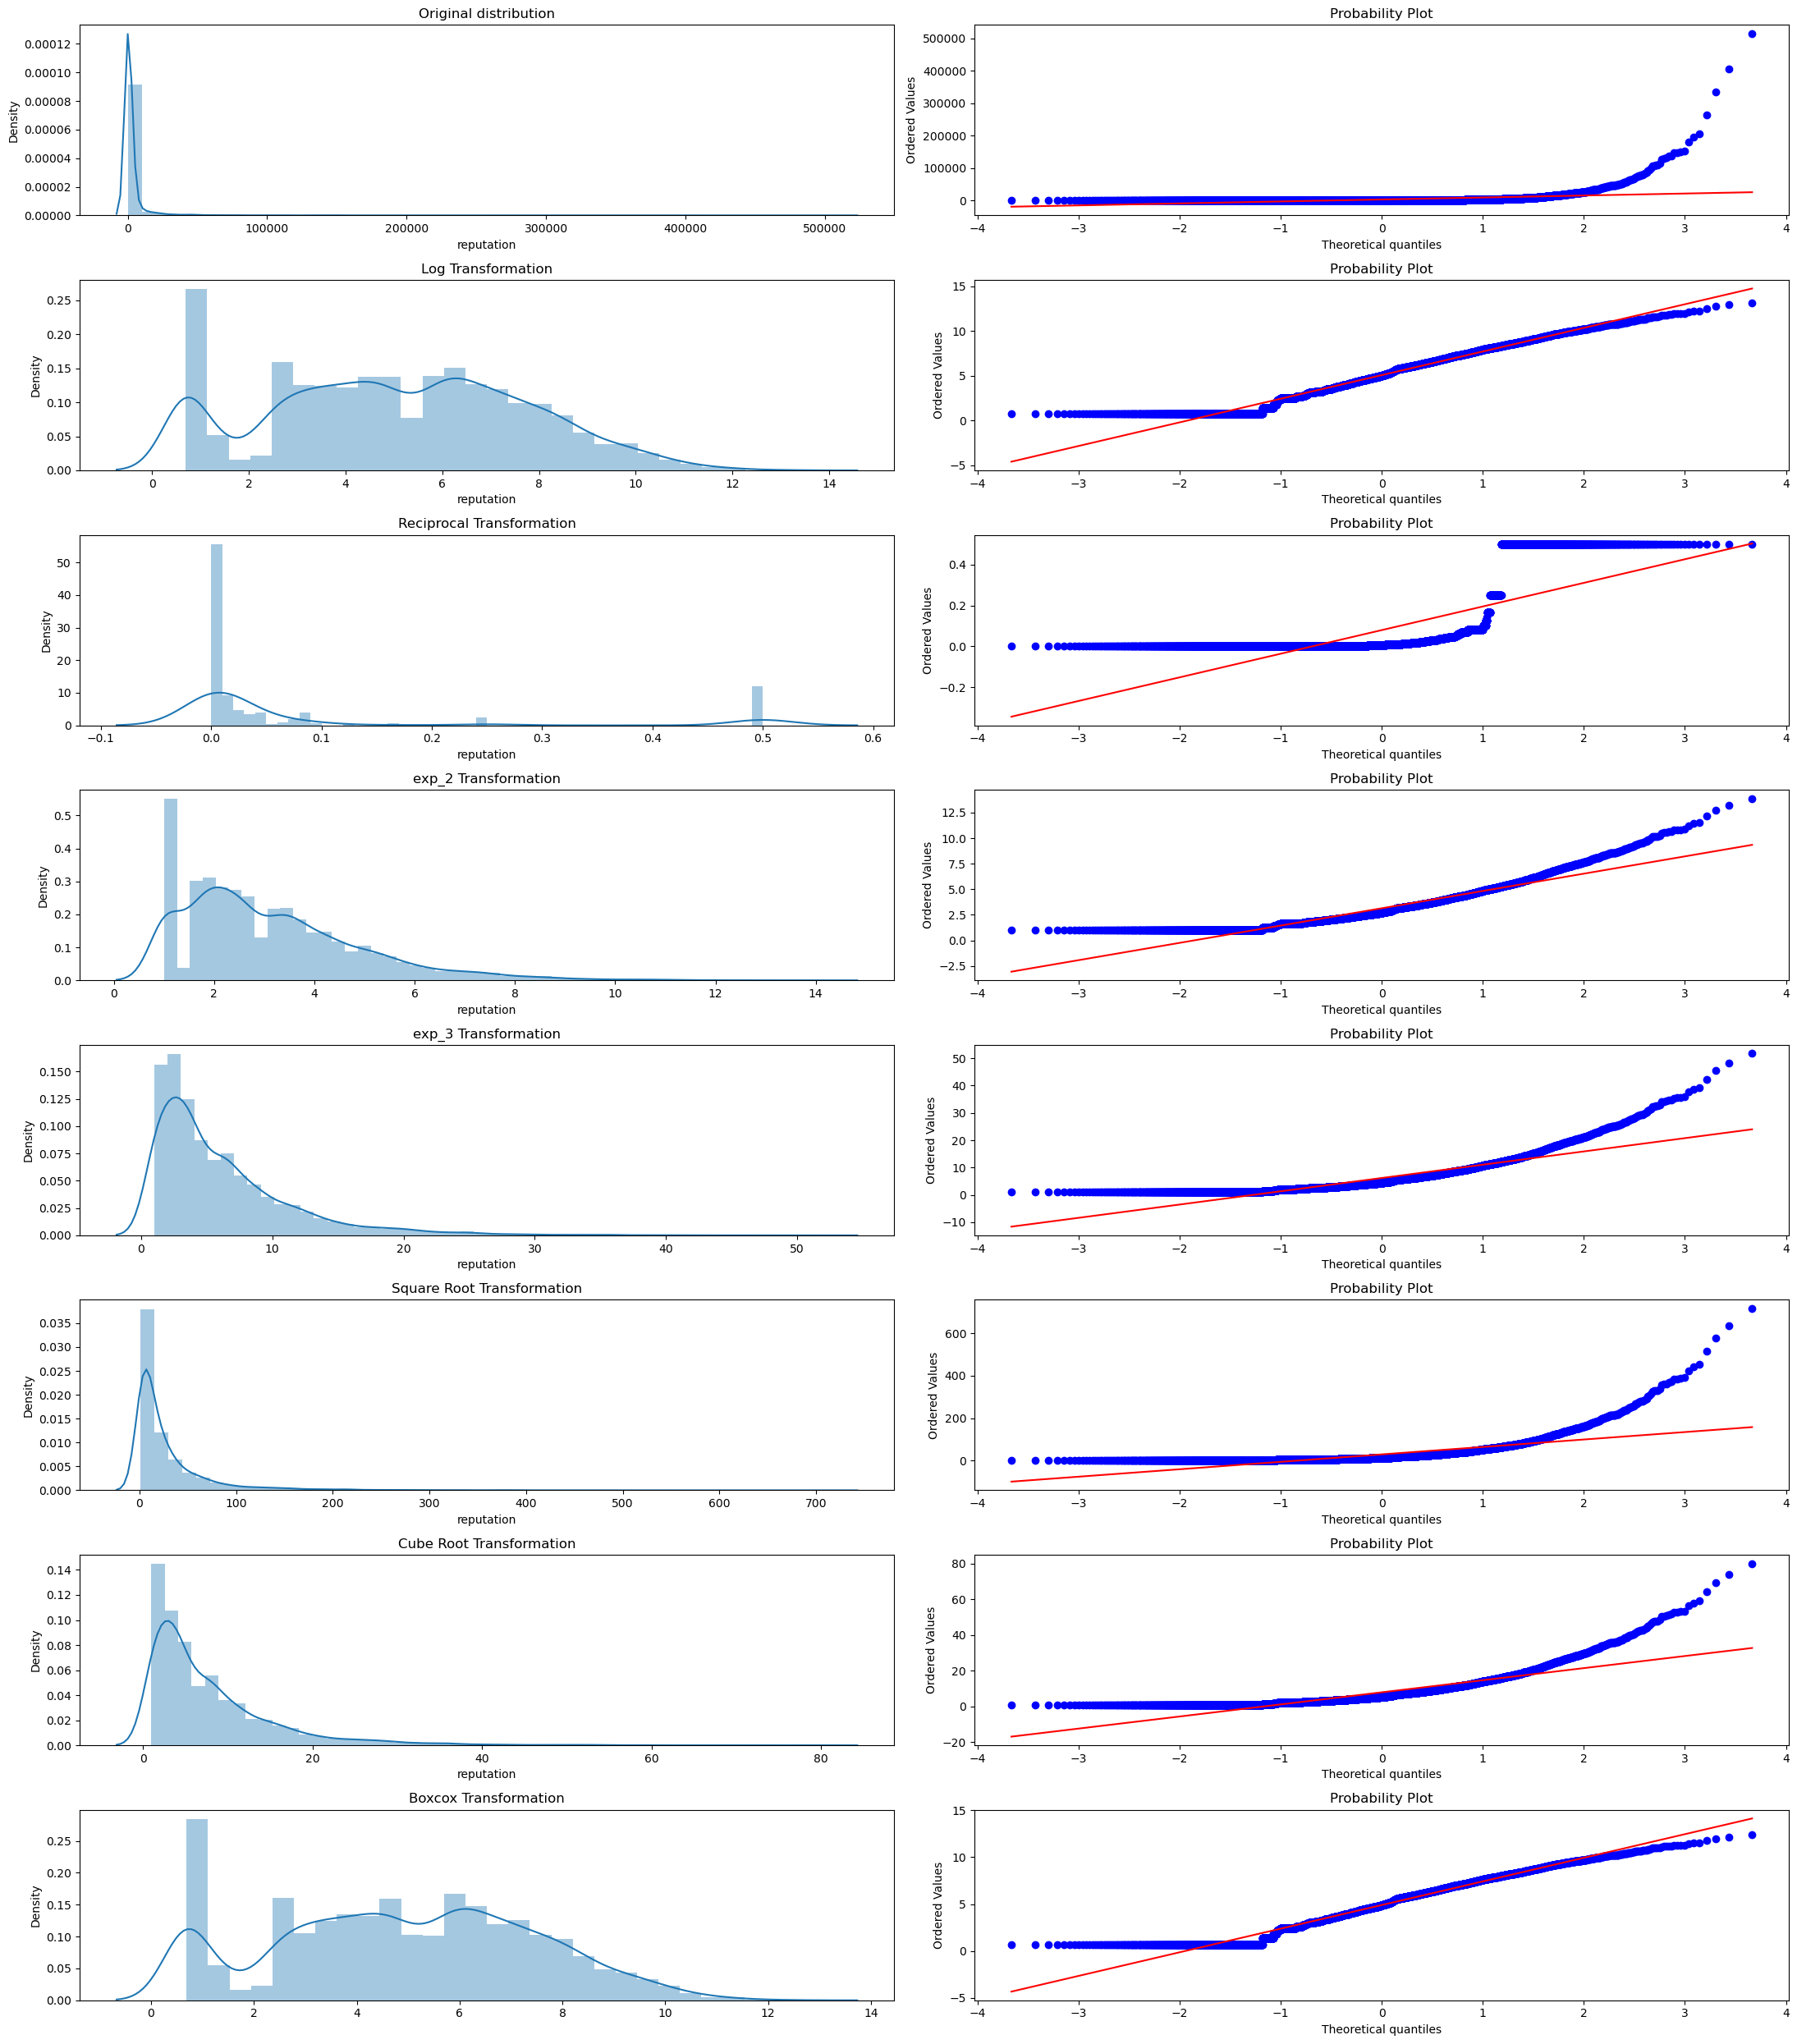

REACHED 

       Transformation      Skew
               Actual 15.218447
                  Log -0.093138
           Reciprocal 34.726939
Exponential power 0.2  1.196601
Exponential power 0.3  2.012635
          Square Root  4.315882
            Cube Root  2.323782
               Boxcox -0.014122

 Best Transformation for  reached : 
 Boxcox = -0.014122073541184561


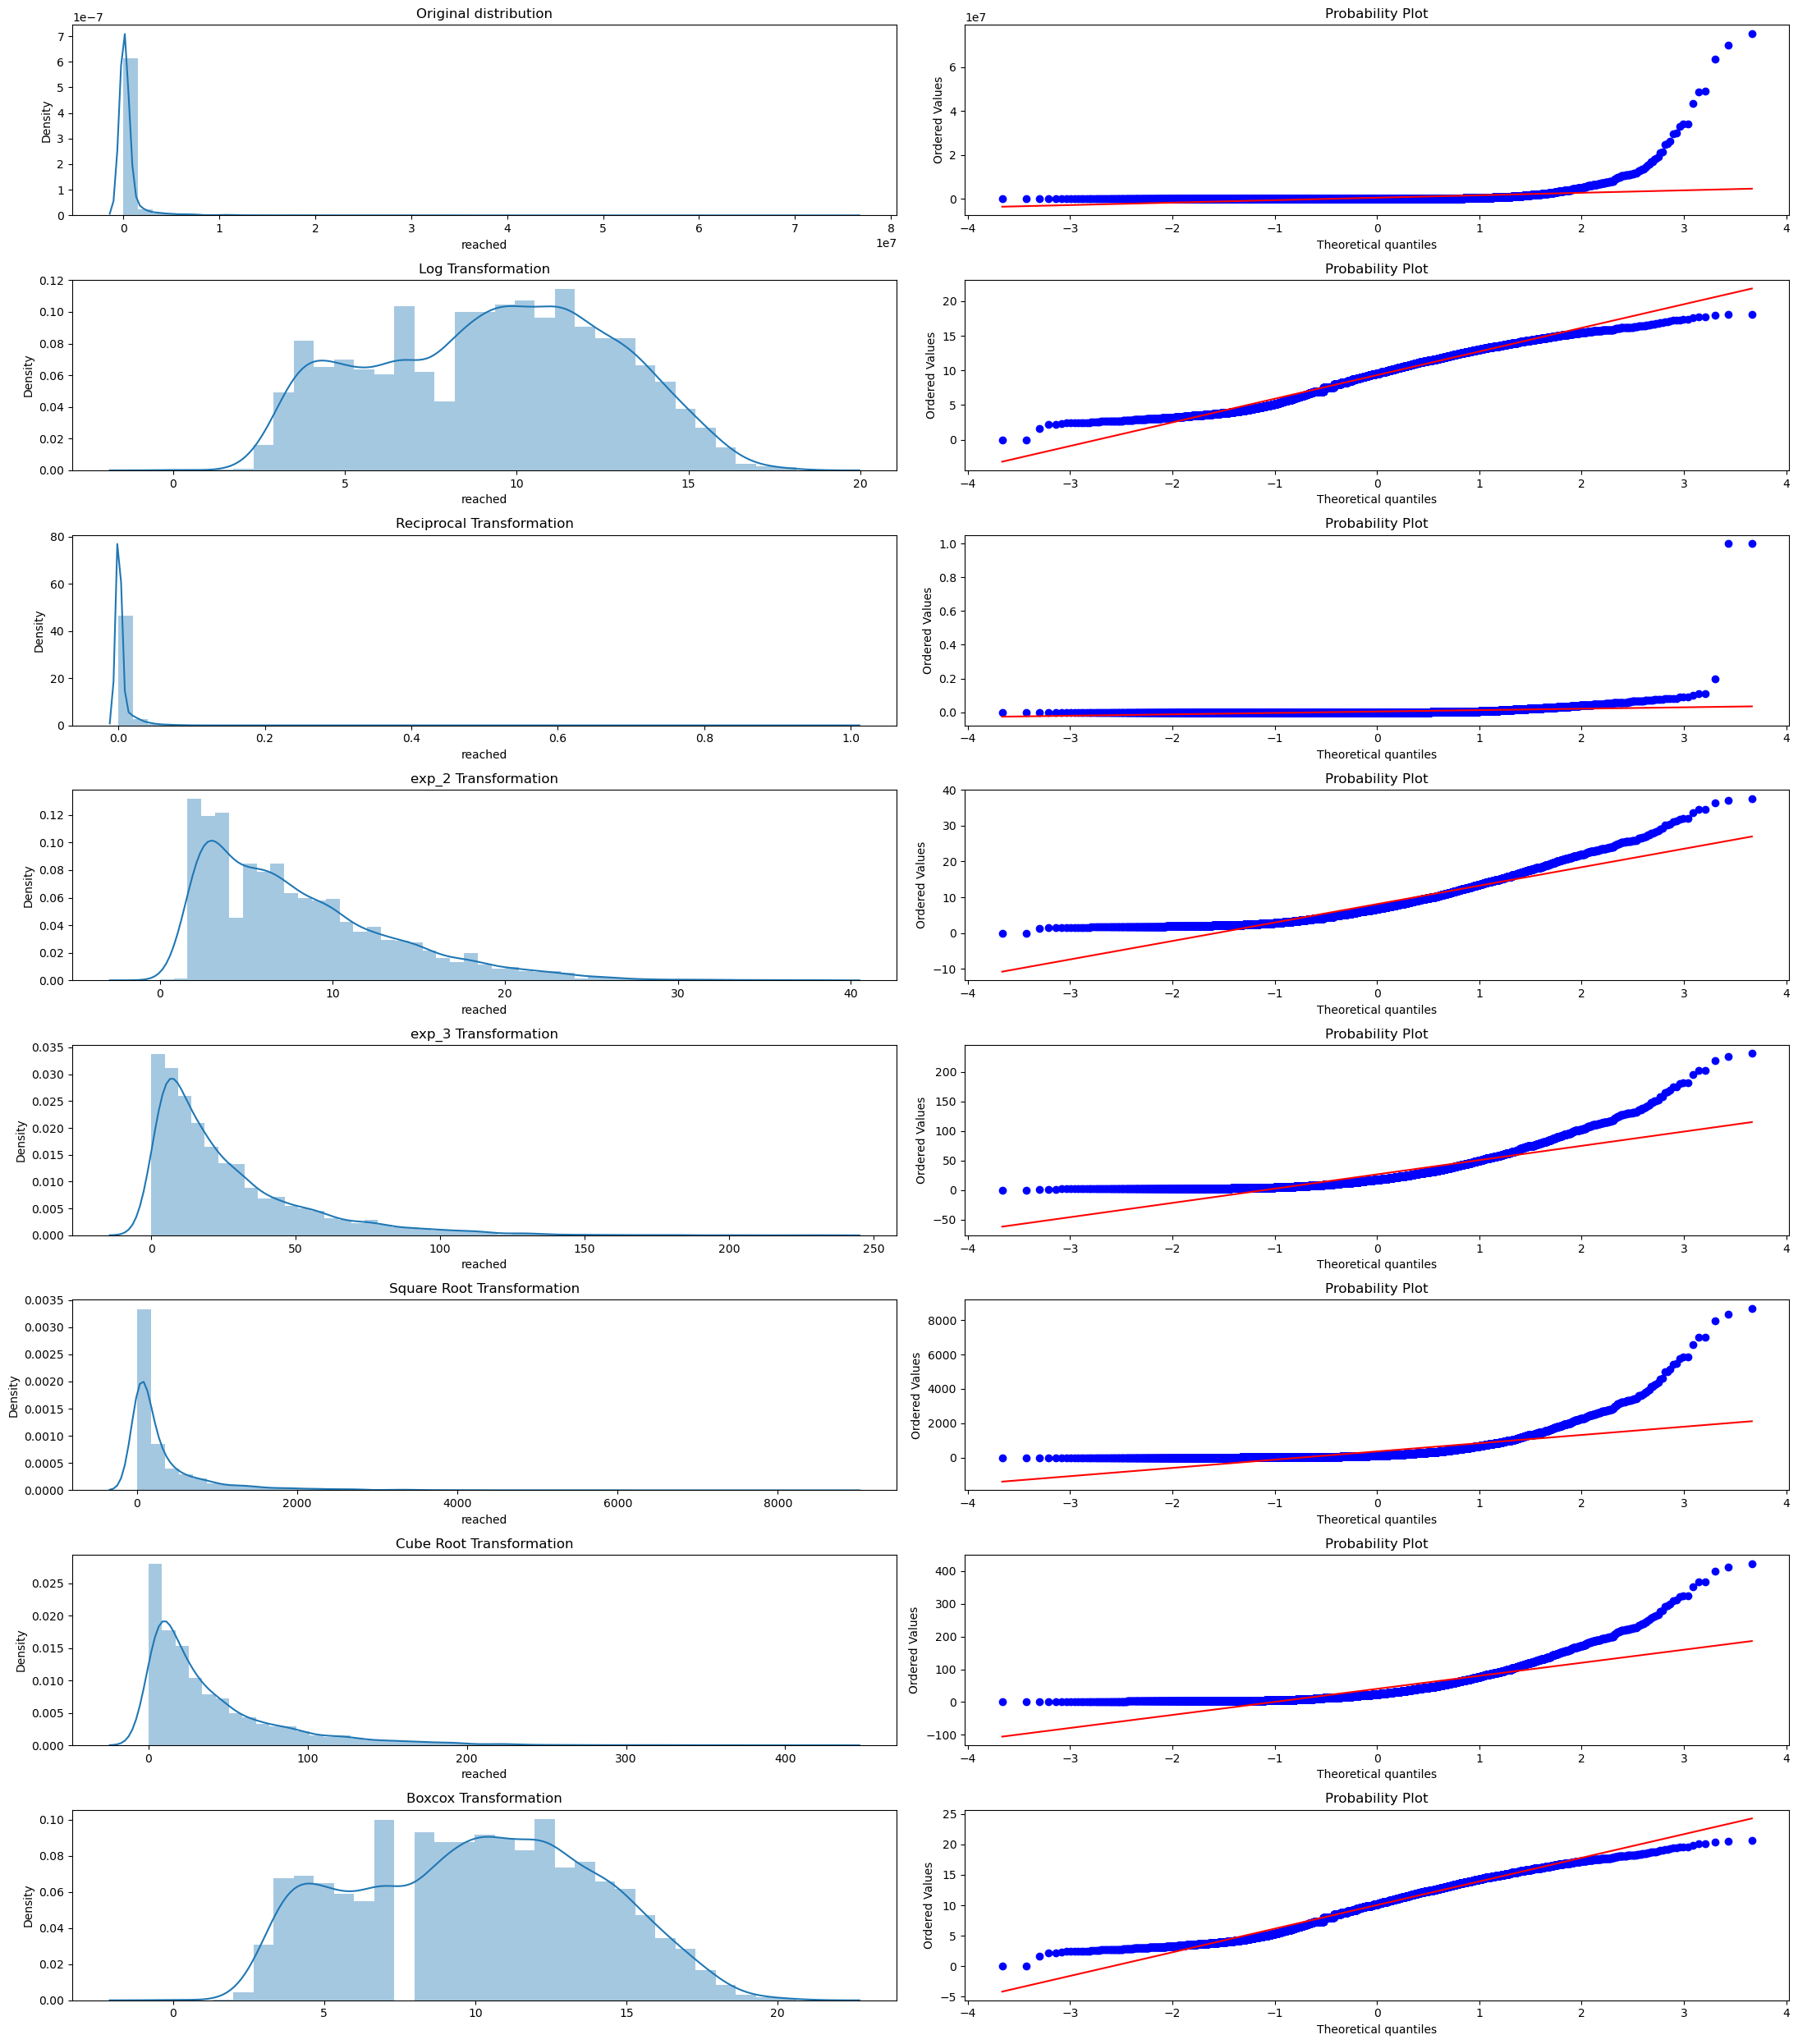

QUESTIONS 

       Transformation     Skew
               Actual 9.722942
                  Log 0.543219
           Reciprocal 1.038984
Exponential power 0.2 0.974180
Exponential power 0.3 1.388531
          Square Root 2.497378
            Cube Root 1.543313
               Boxcox 0.097537

 Best Transformation for  questions : 
 Boxcox = 0.09753705760483244


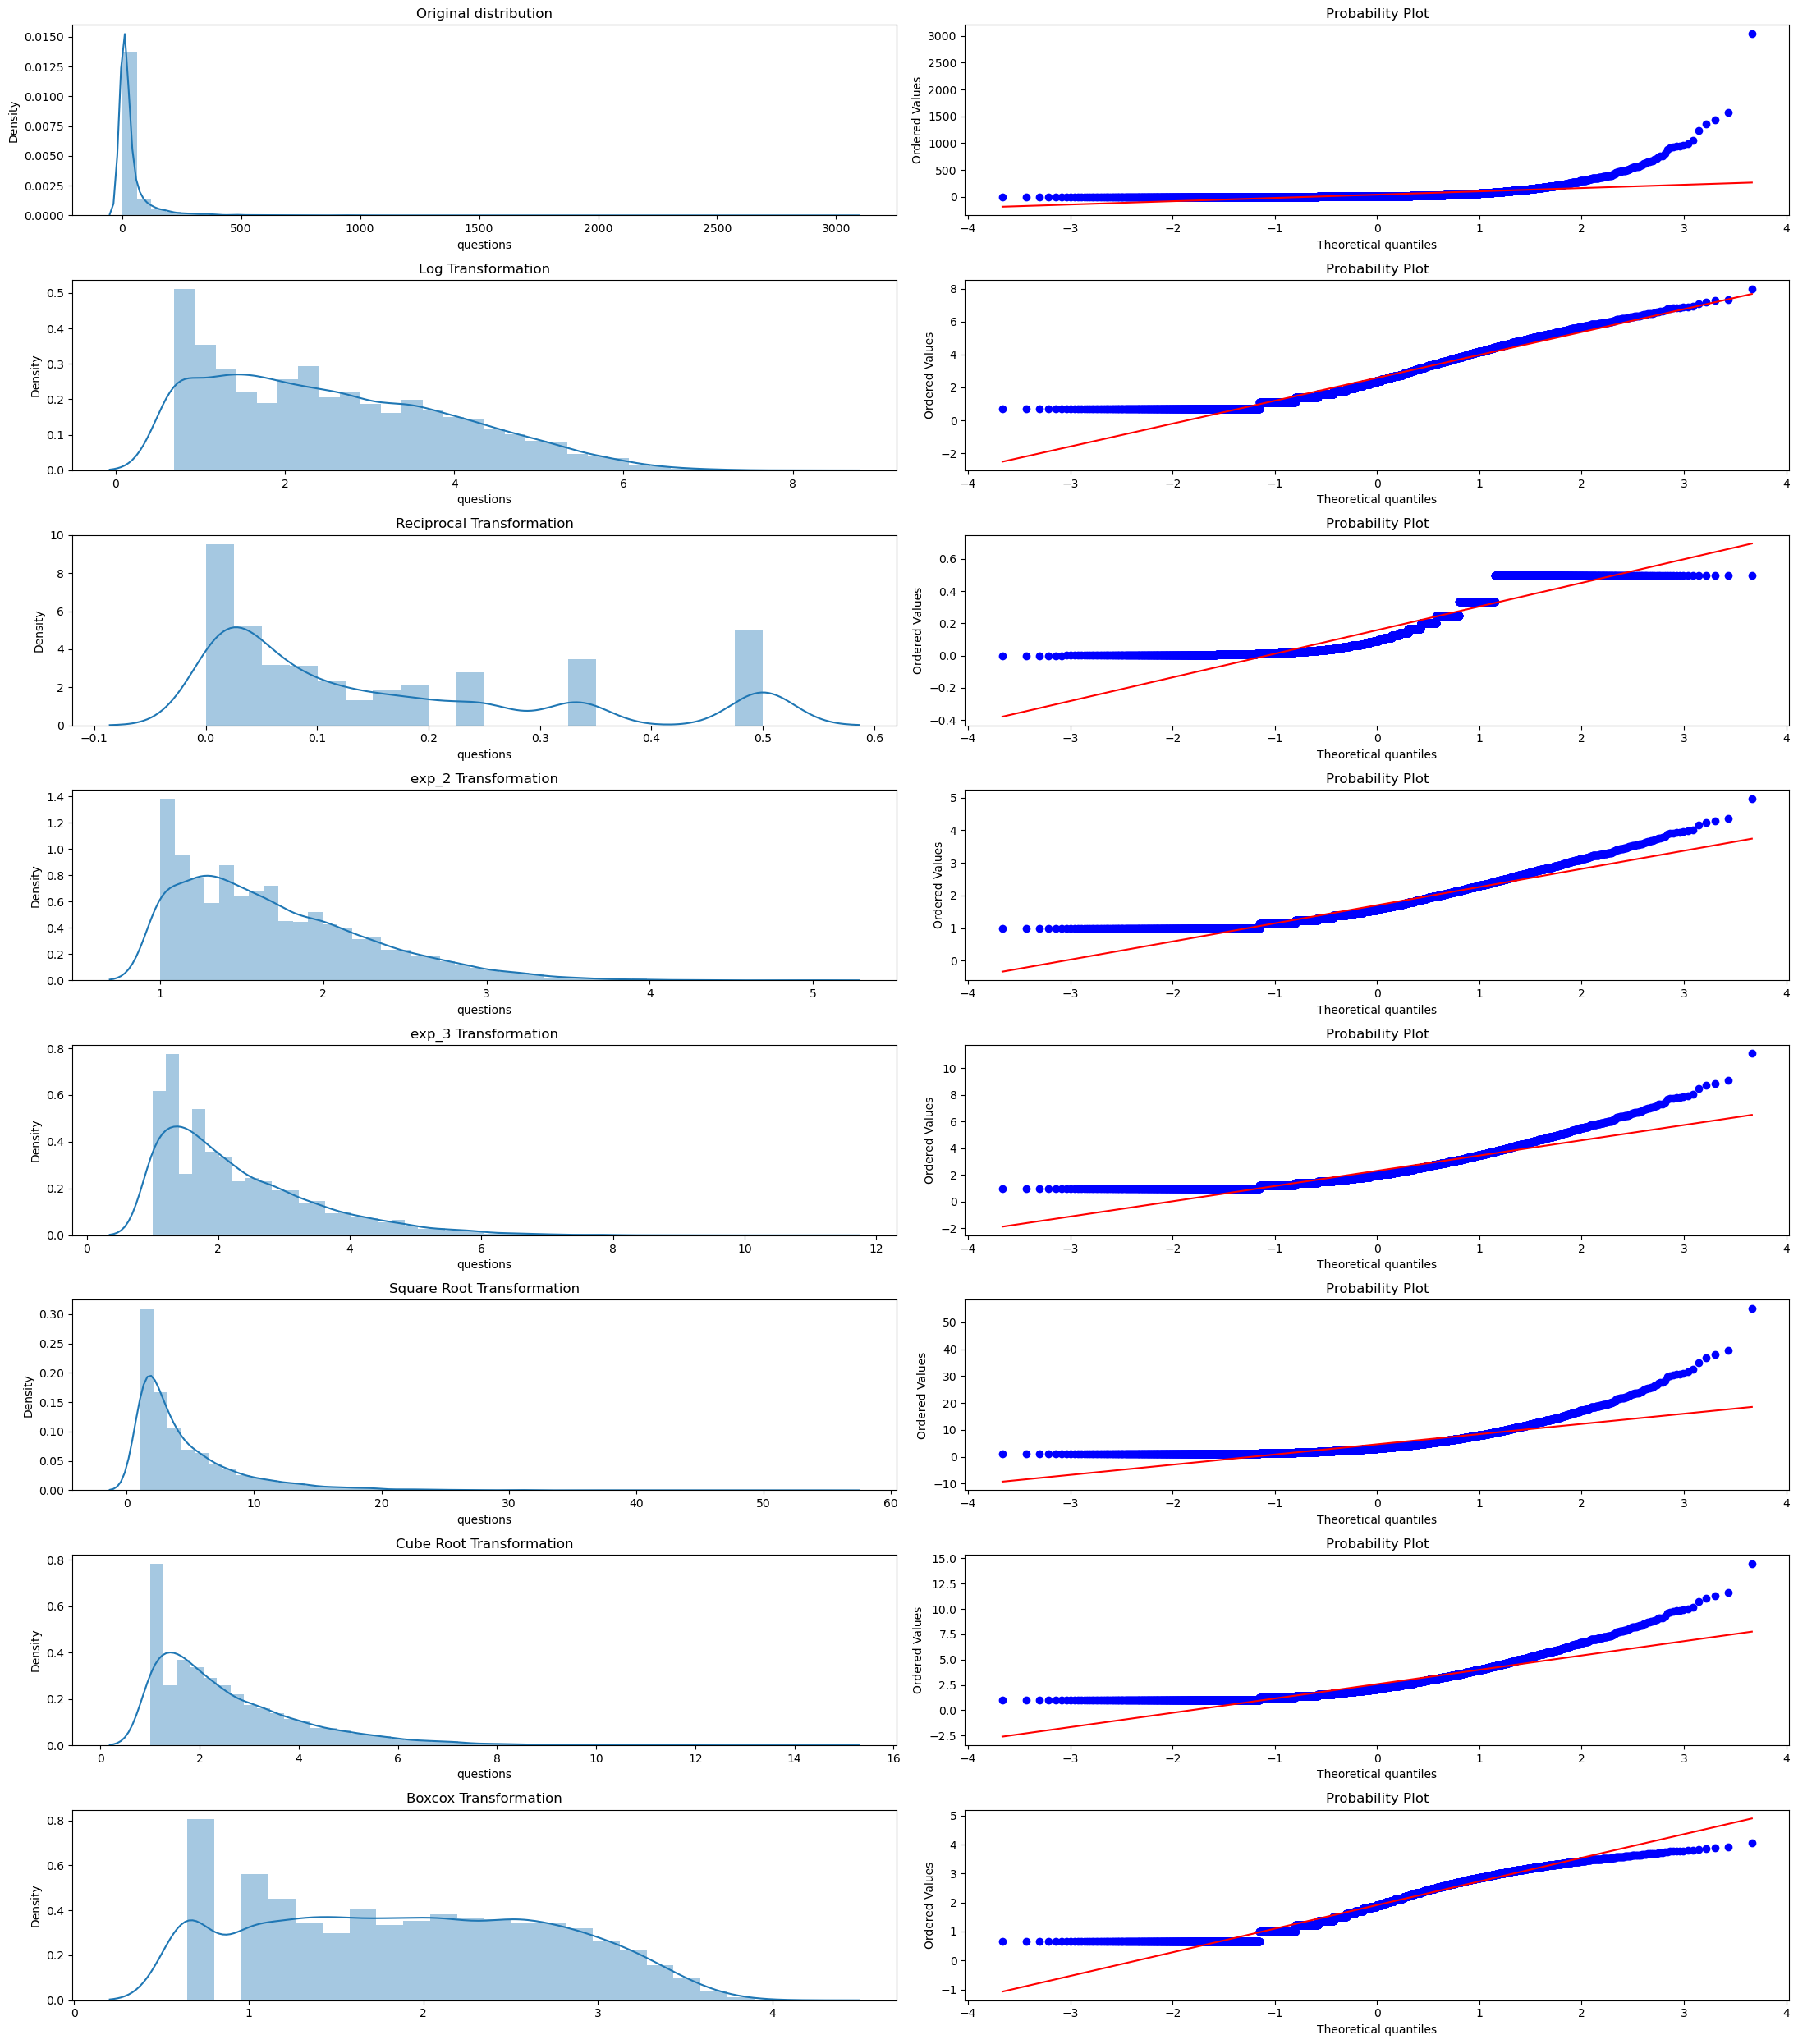

ANSWERS 

       Transformation      Skew
               Actual 20.454167
                  Log  1.033065
           Reciprocal  0.275099
Exponential power 0.2  0.571607
Exponential power 0.3  1.923383
          Square Root  6.079143
            Cube Root  2.475751
               Boxcox  0.269630

 Best Transformation for  answers : 
 Boxcox = 0.26962984067206547


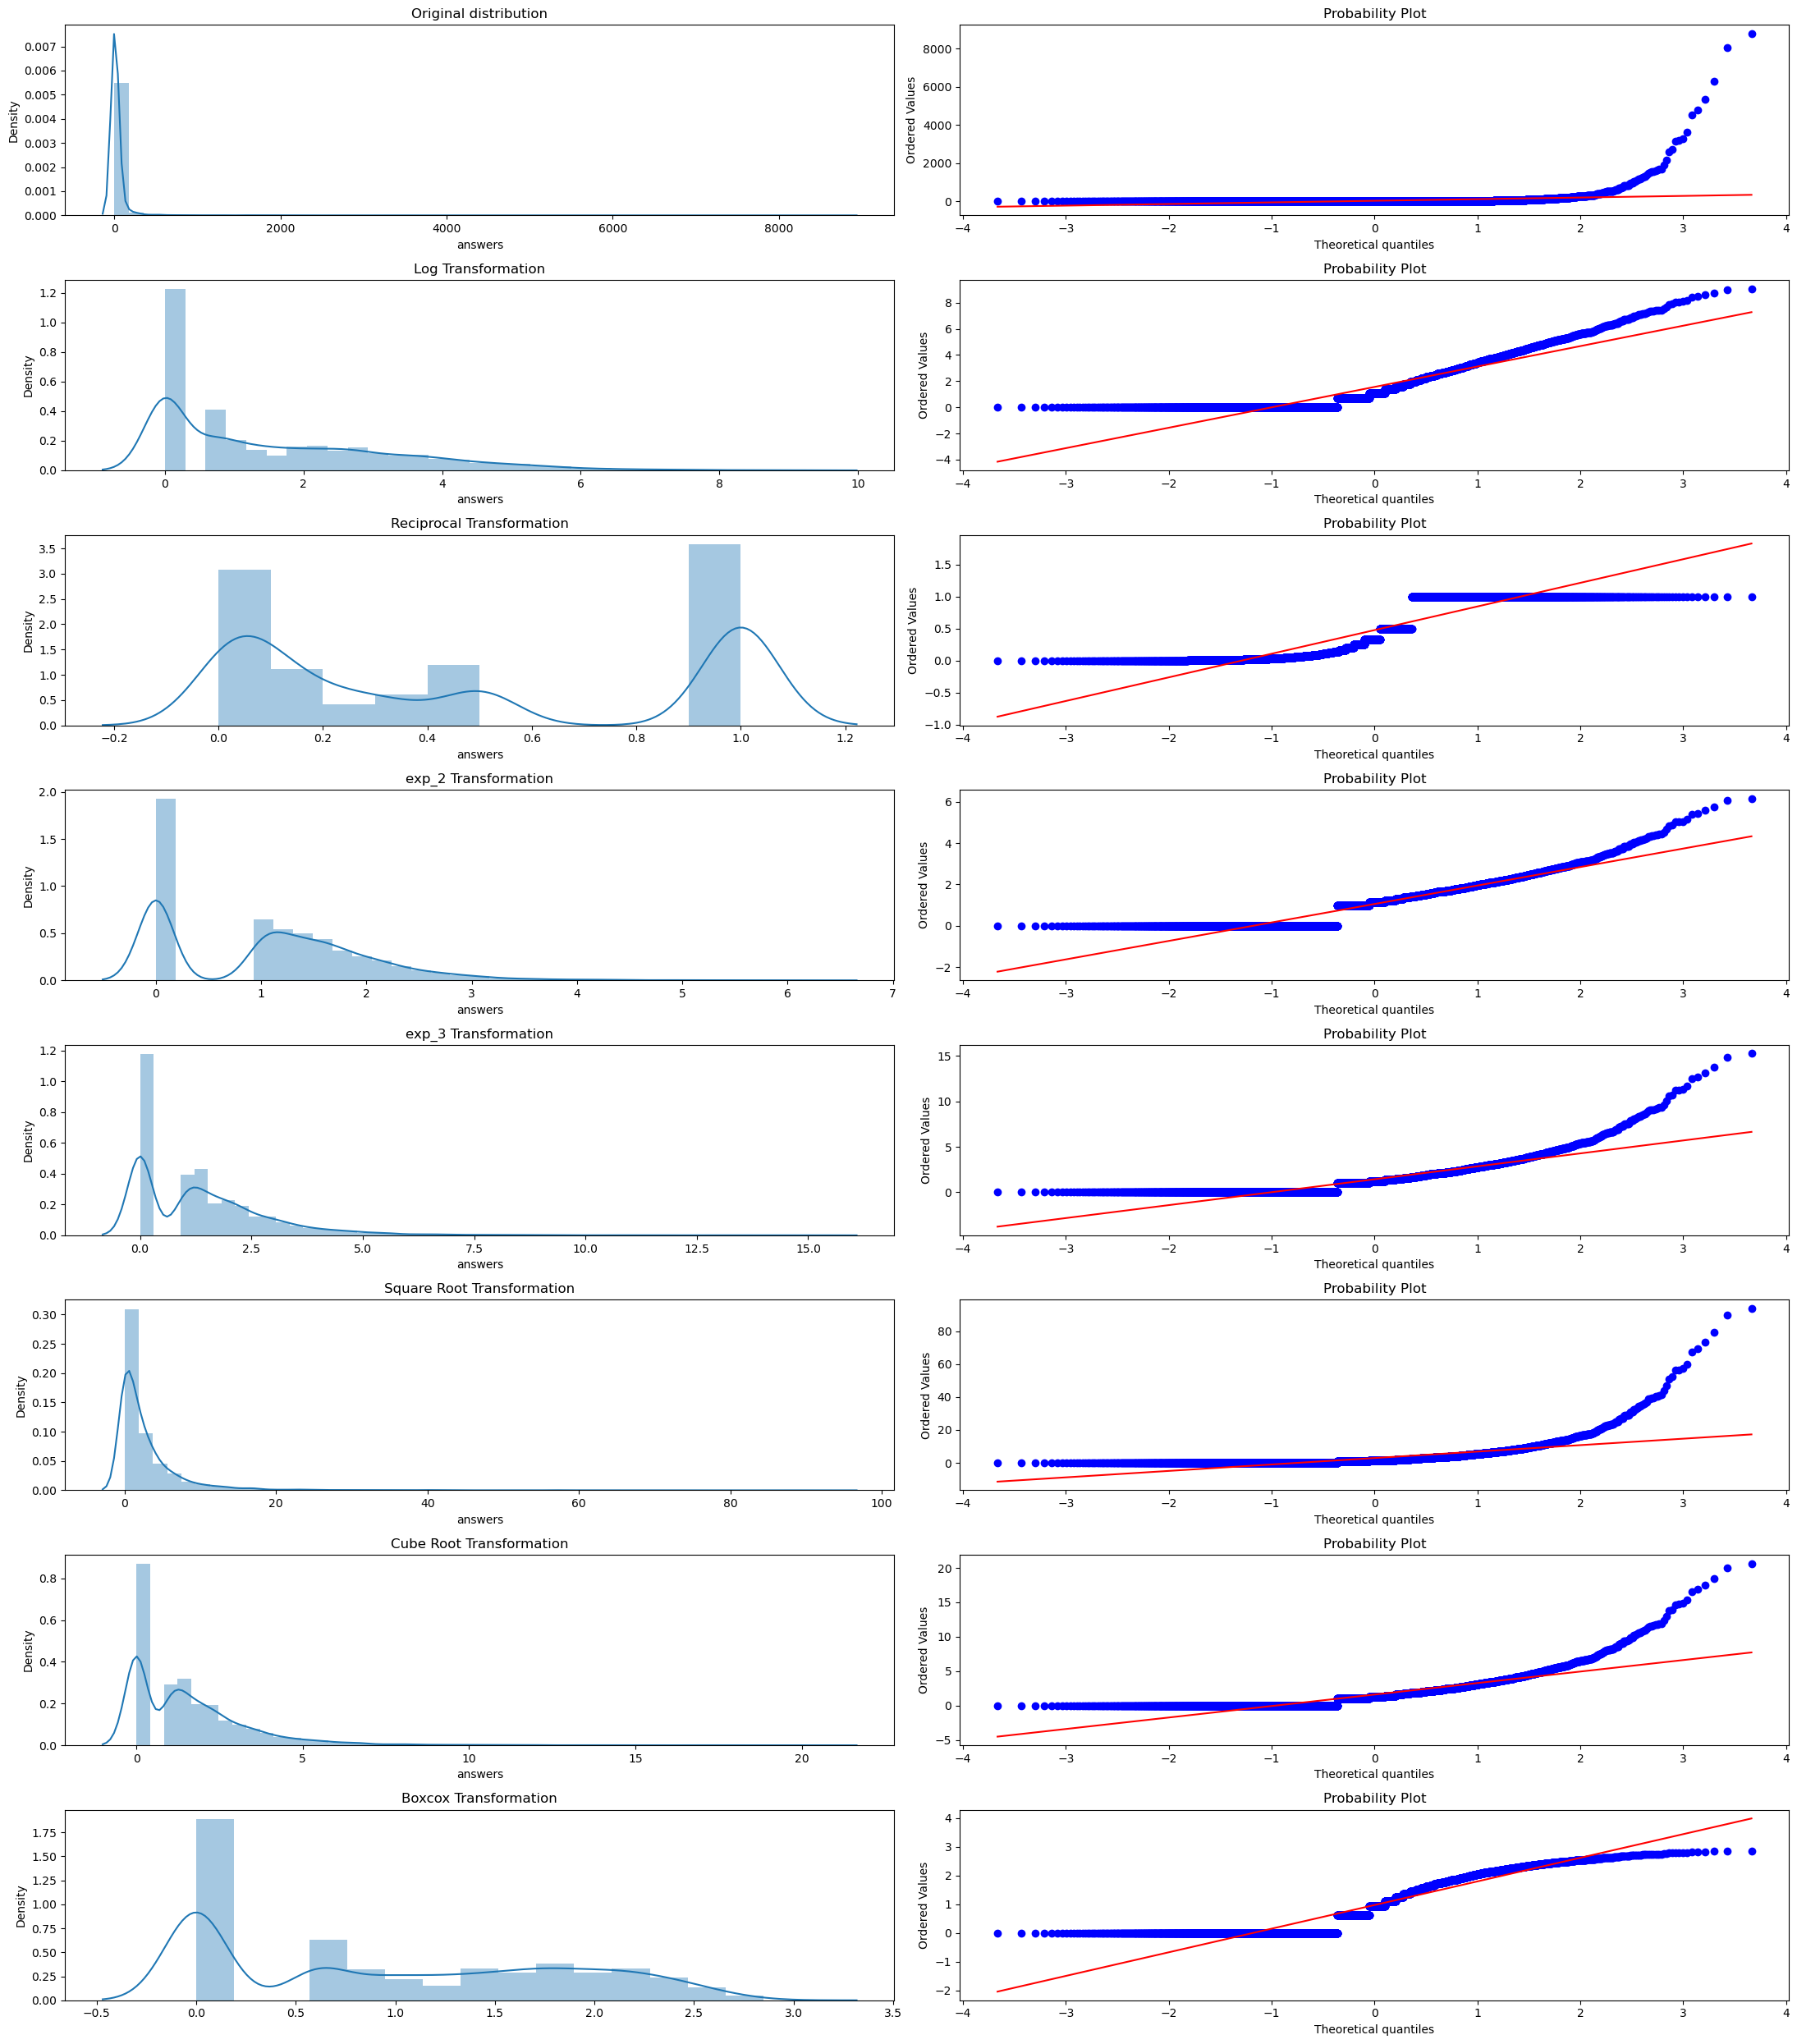

POSTS_EDITED 

       Transformation      Skew
               Actual 26.617154
                  Log  2.985575
           Reciprocal -1.529427
Exponential power 0.2  2.322976
Exponential power 0.3  3.867343
          Square Root  8.815193
            Cube Root  4.535073
               Boxcox  1.389215

 Best Transformation for  posts_edited : 
 Boxcox = 1.3892151172315395


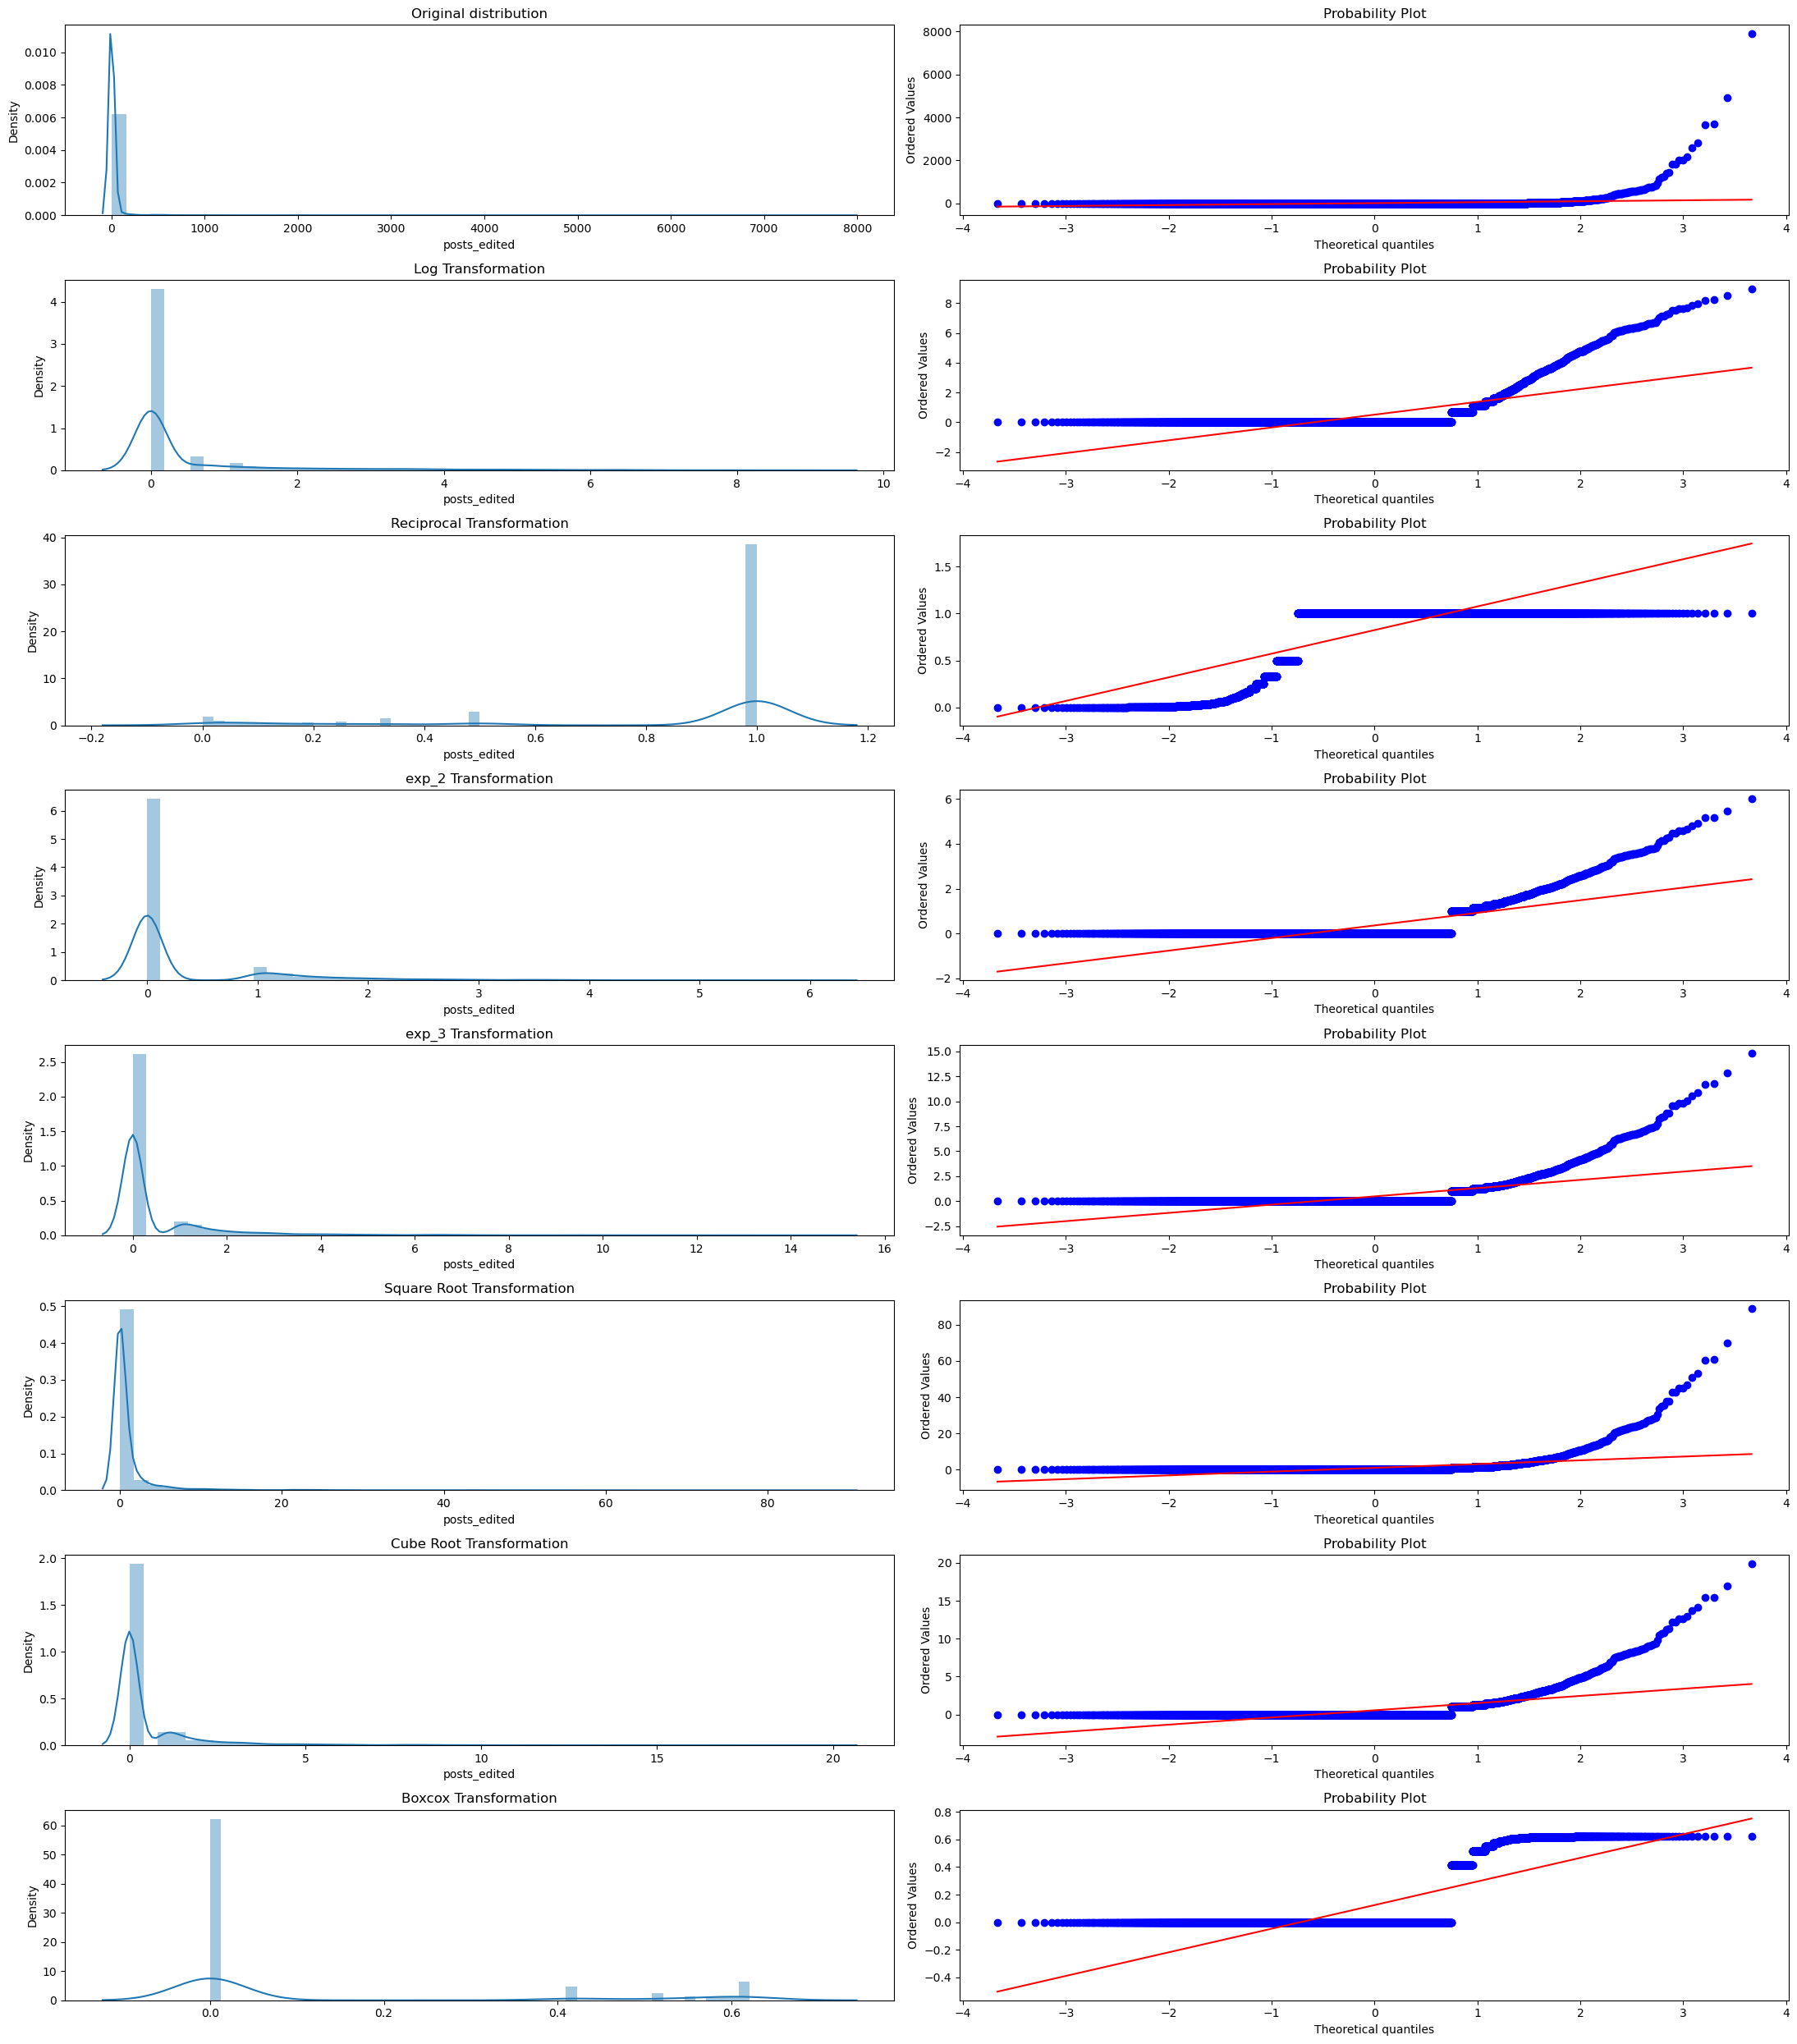

HELPFUL_TAGS 

       Transformation      Skew
               Actual 66.392585
                  Log  3.726310
           Reciprocal -1.853367
Exponential power 0.2  2.671487
Exponential power 0.3  4.899550
          Square Root 17.165520
            Cube Root  6.080923
               Boxcox  1.613288

 Best Transformation for  helpful_tags : 
 Boxcox = 1.6132876390530049


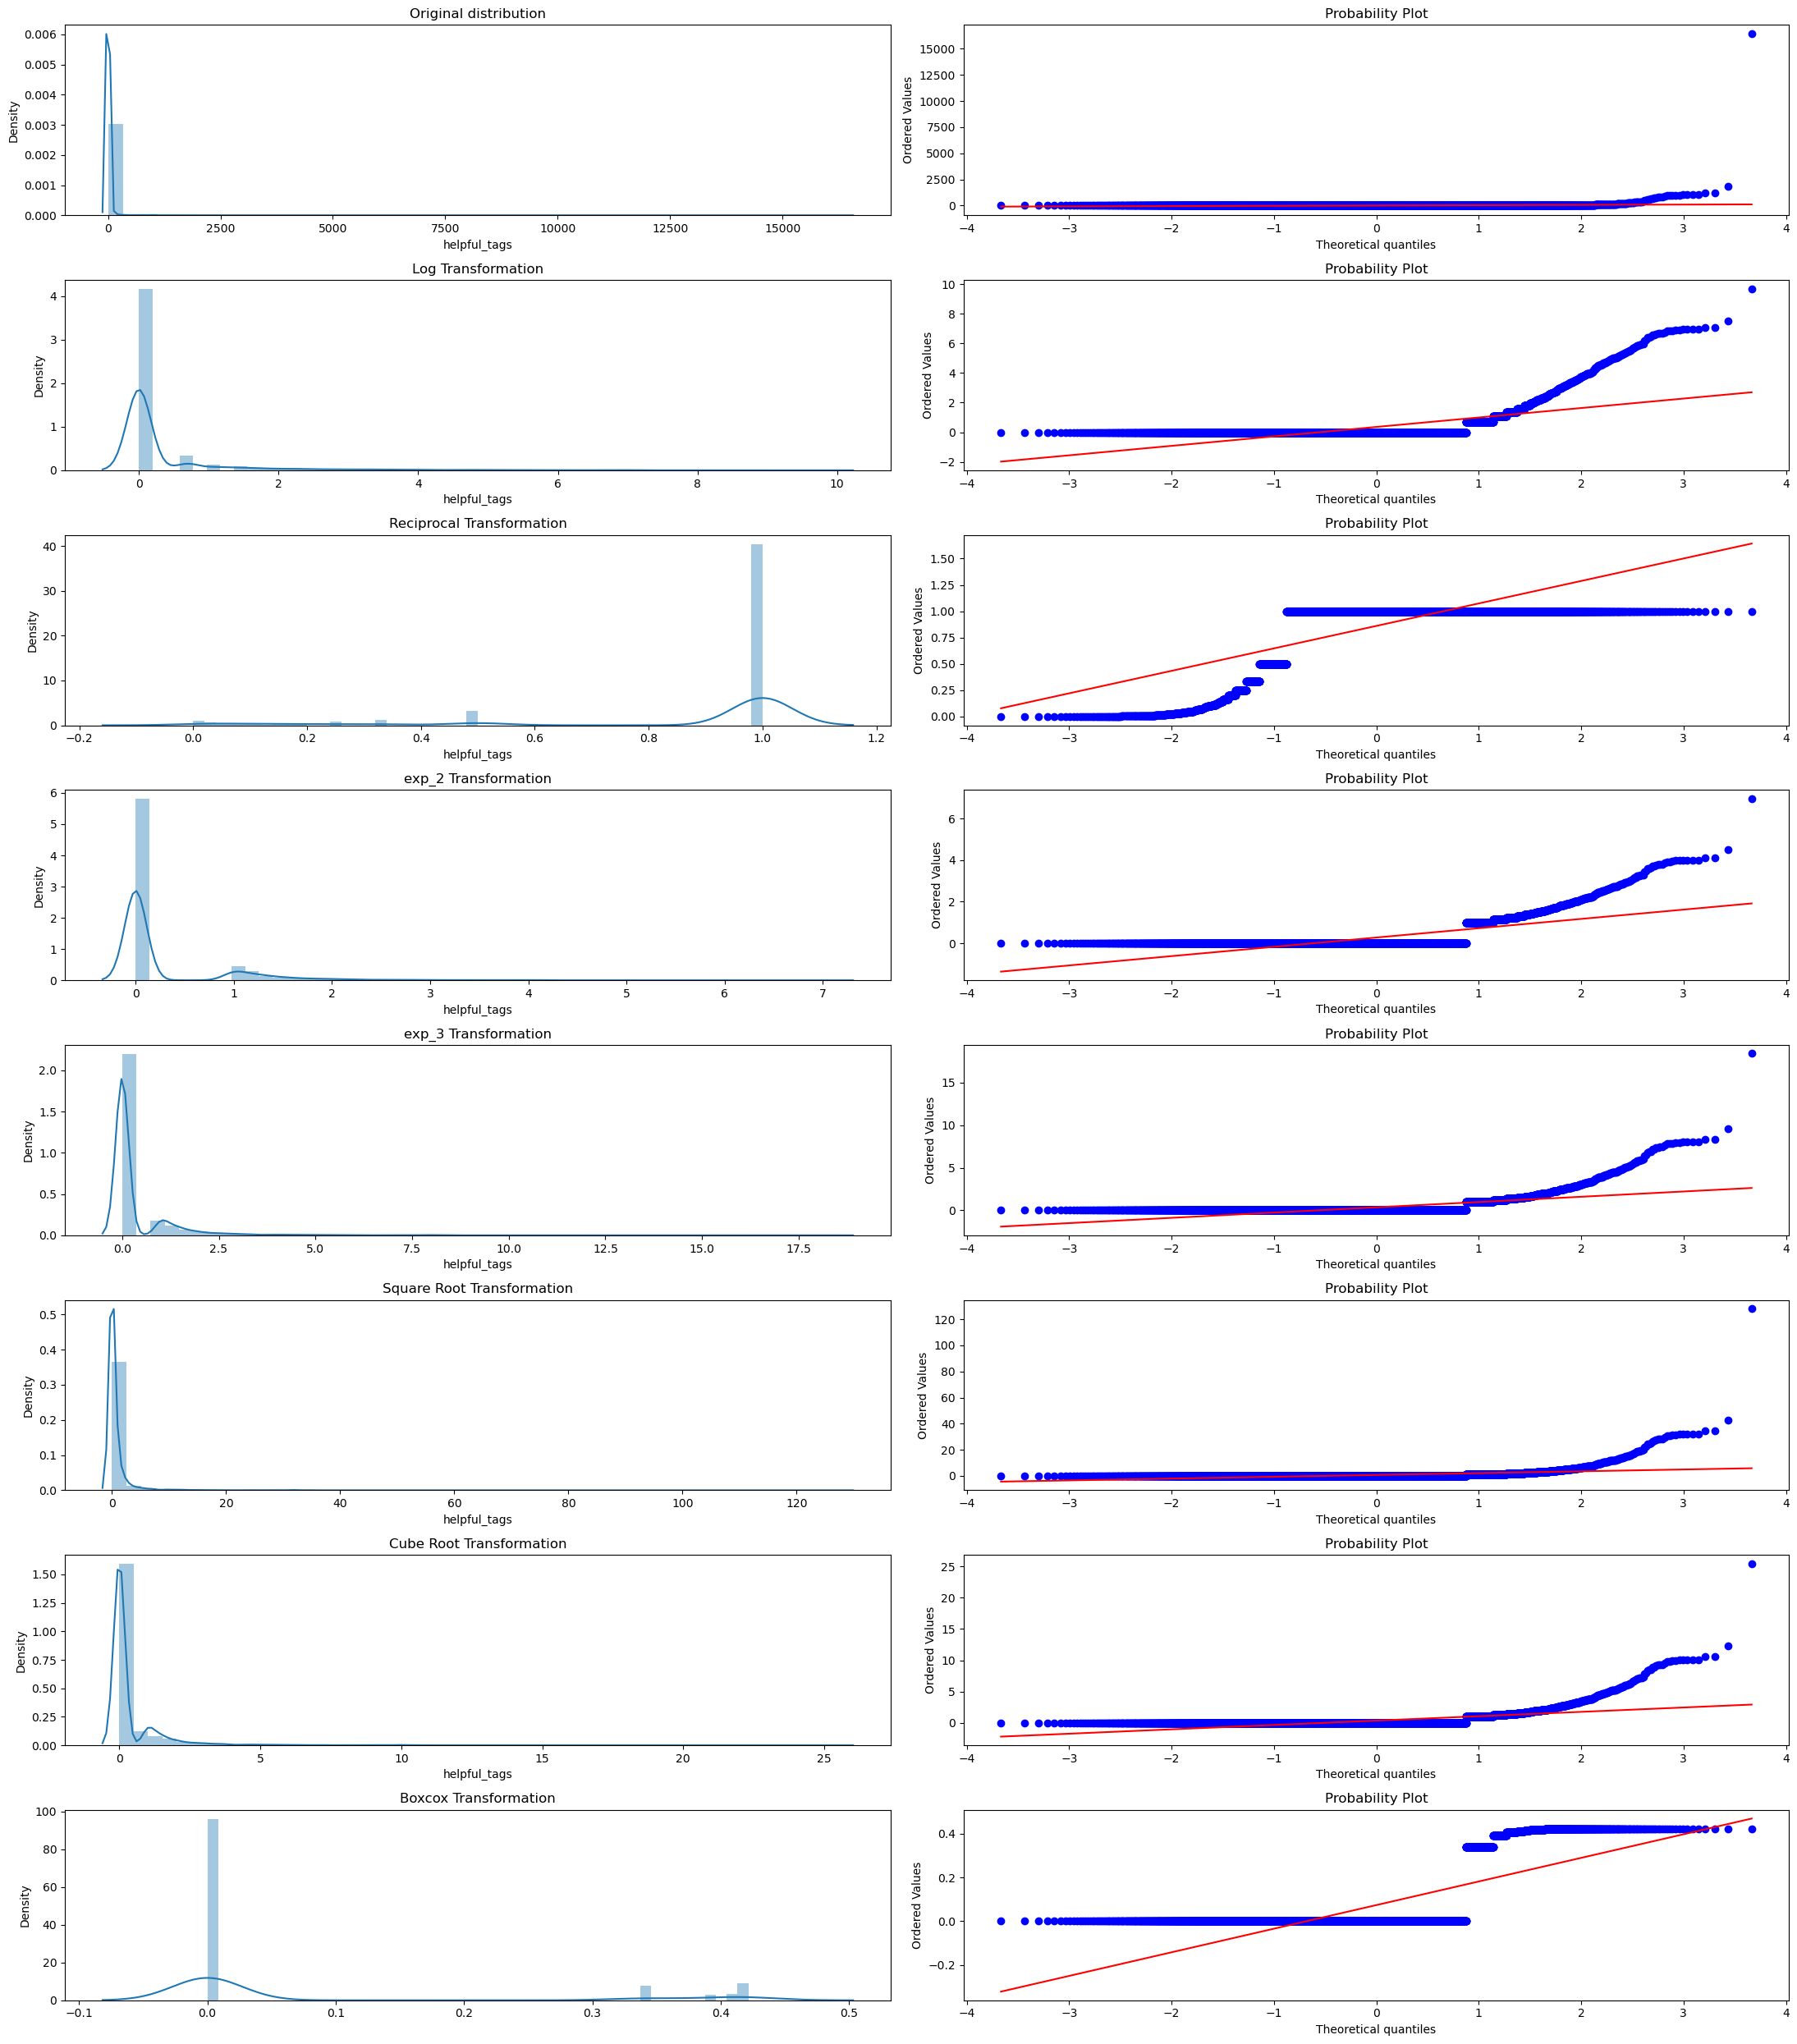

VOTES_CAST 

       Transformation      Skew
               Actual 38.117973
                  Log  0.465458
           Reciprocal  0.661241
Exponential power 0.2  0.545613
Exponential power 0.3  1.546481
          Square Root  4.816903
            Cube Root  1.918276
               Boxcox  0.142485

 Best Transformation for  votes_cast : 
 Boxcox = 0.1424850195985118


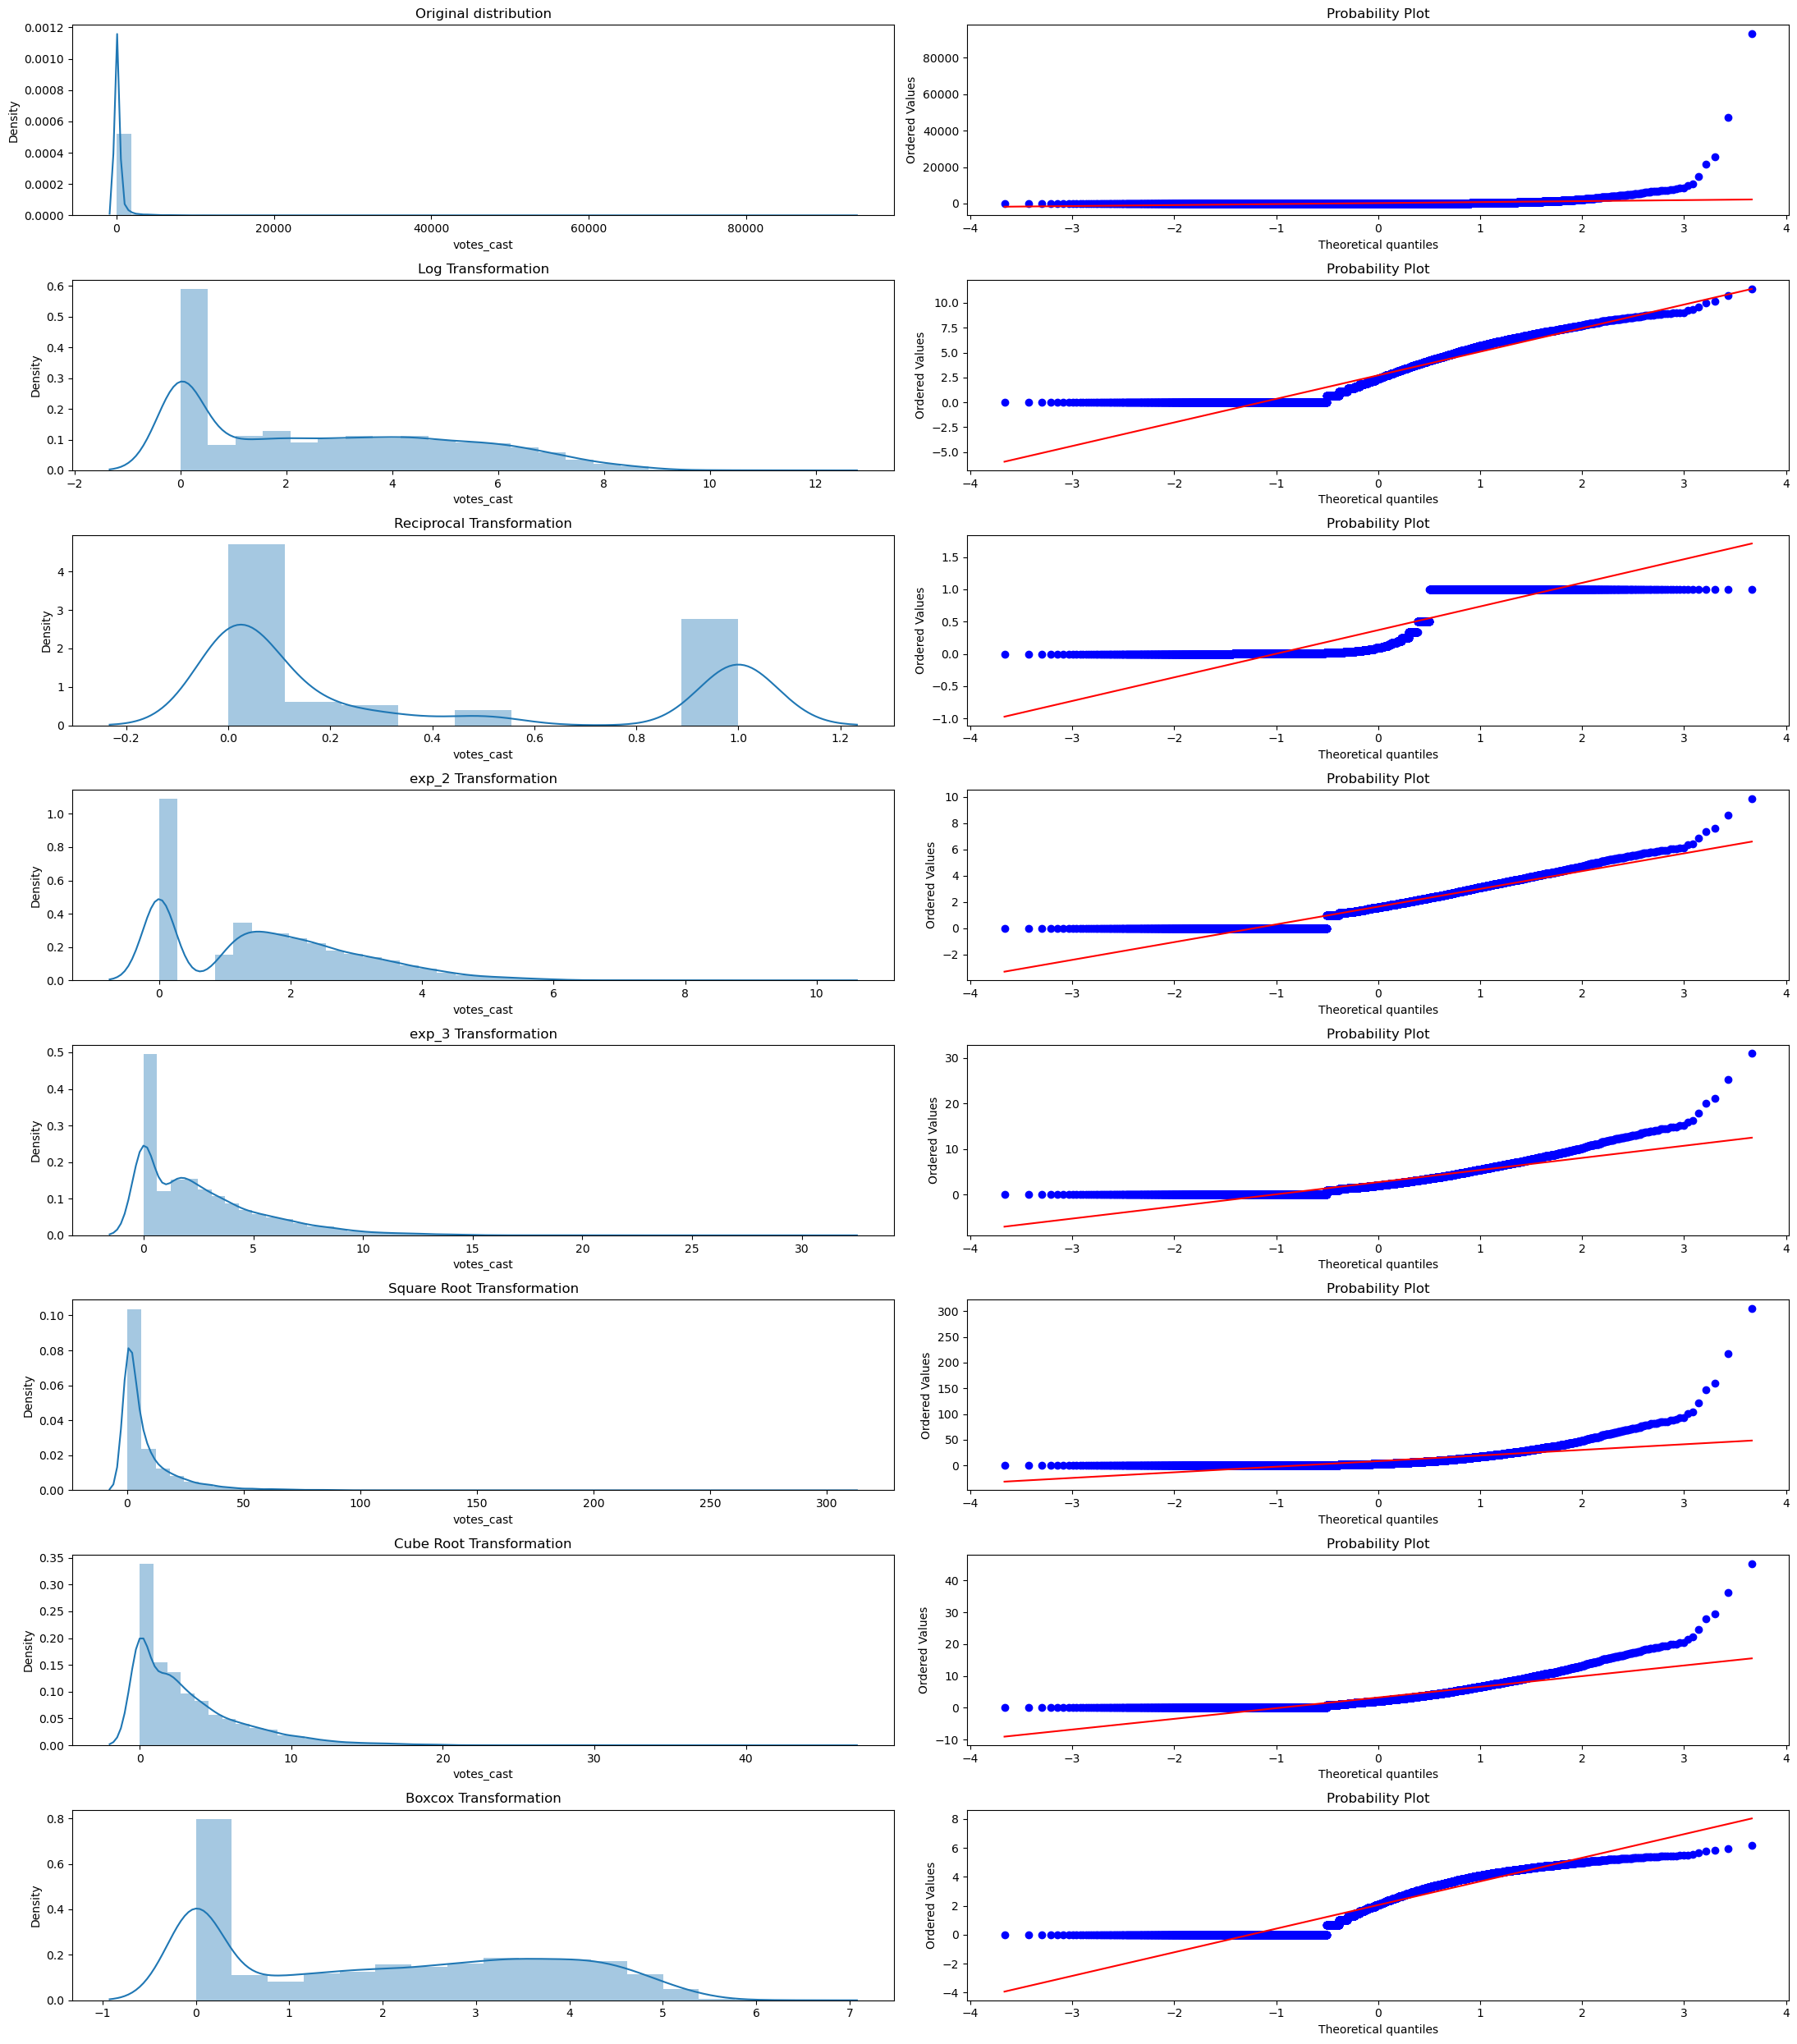

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual  7.759029
                  Log  0.011252
           Reciprocal  3.786063
Exponential power 0.2 -0.124902
Exponential power 0.3  1.052029
          Square Root  2.610917
            Cube Root  1.340690
               Boxcox -0.000265

 Best Transformation for  weighted_badge_score : 
 Boxcox = -0.0002646964132016294


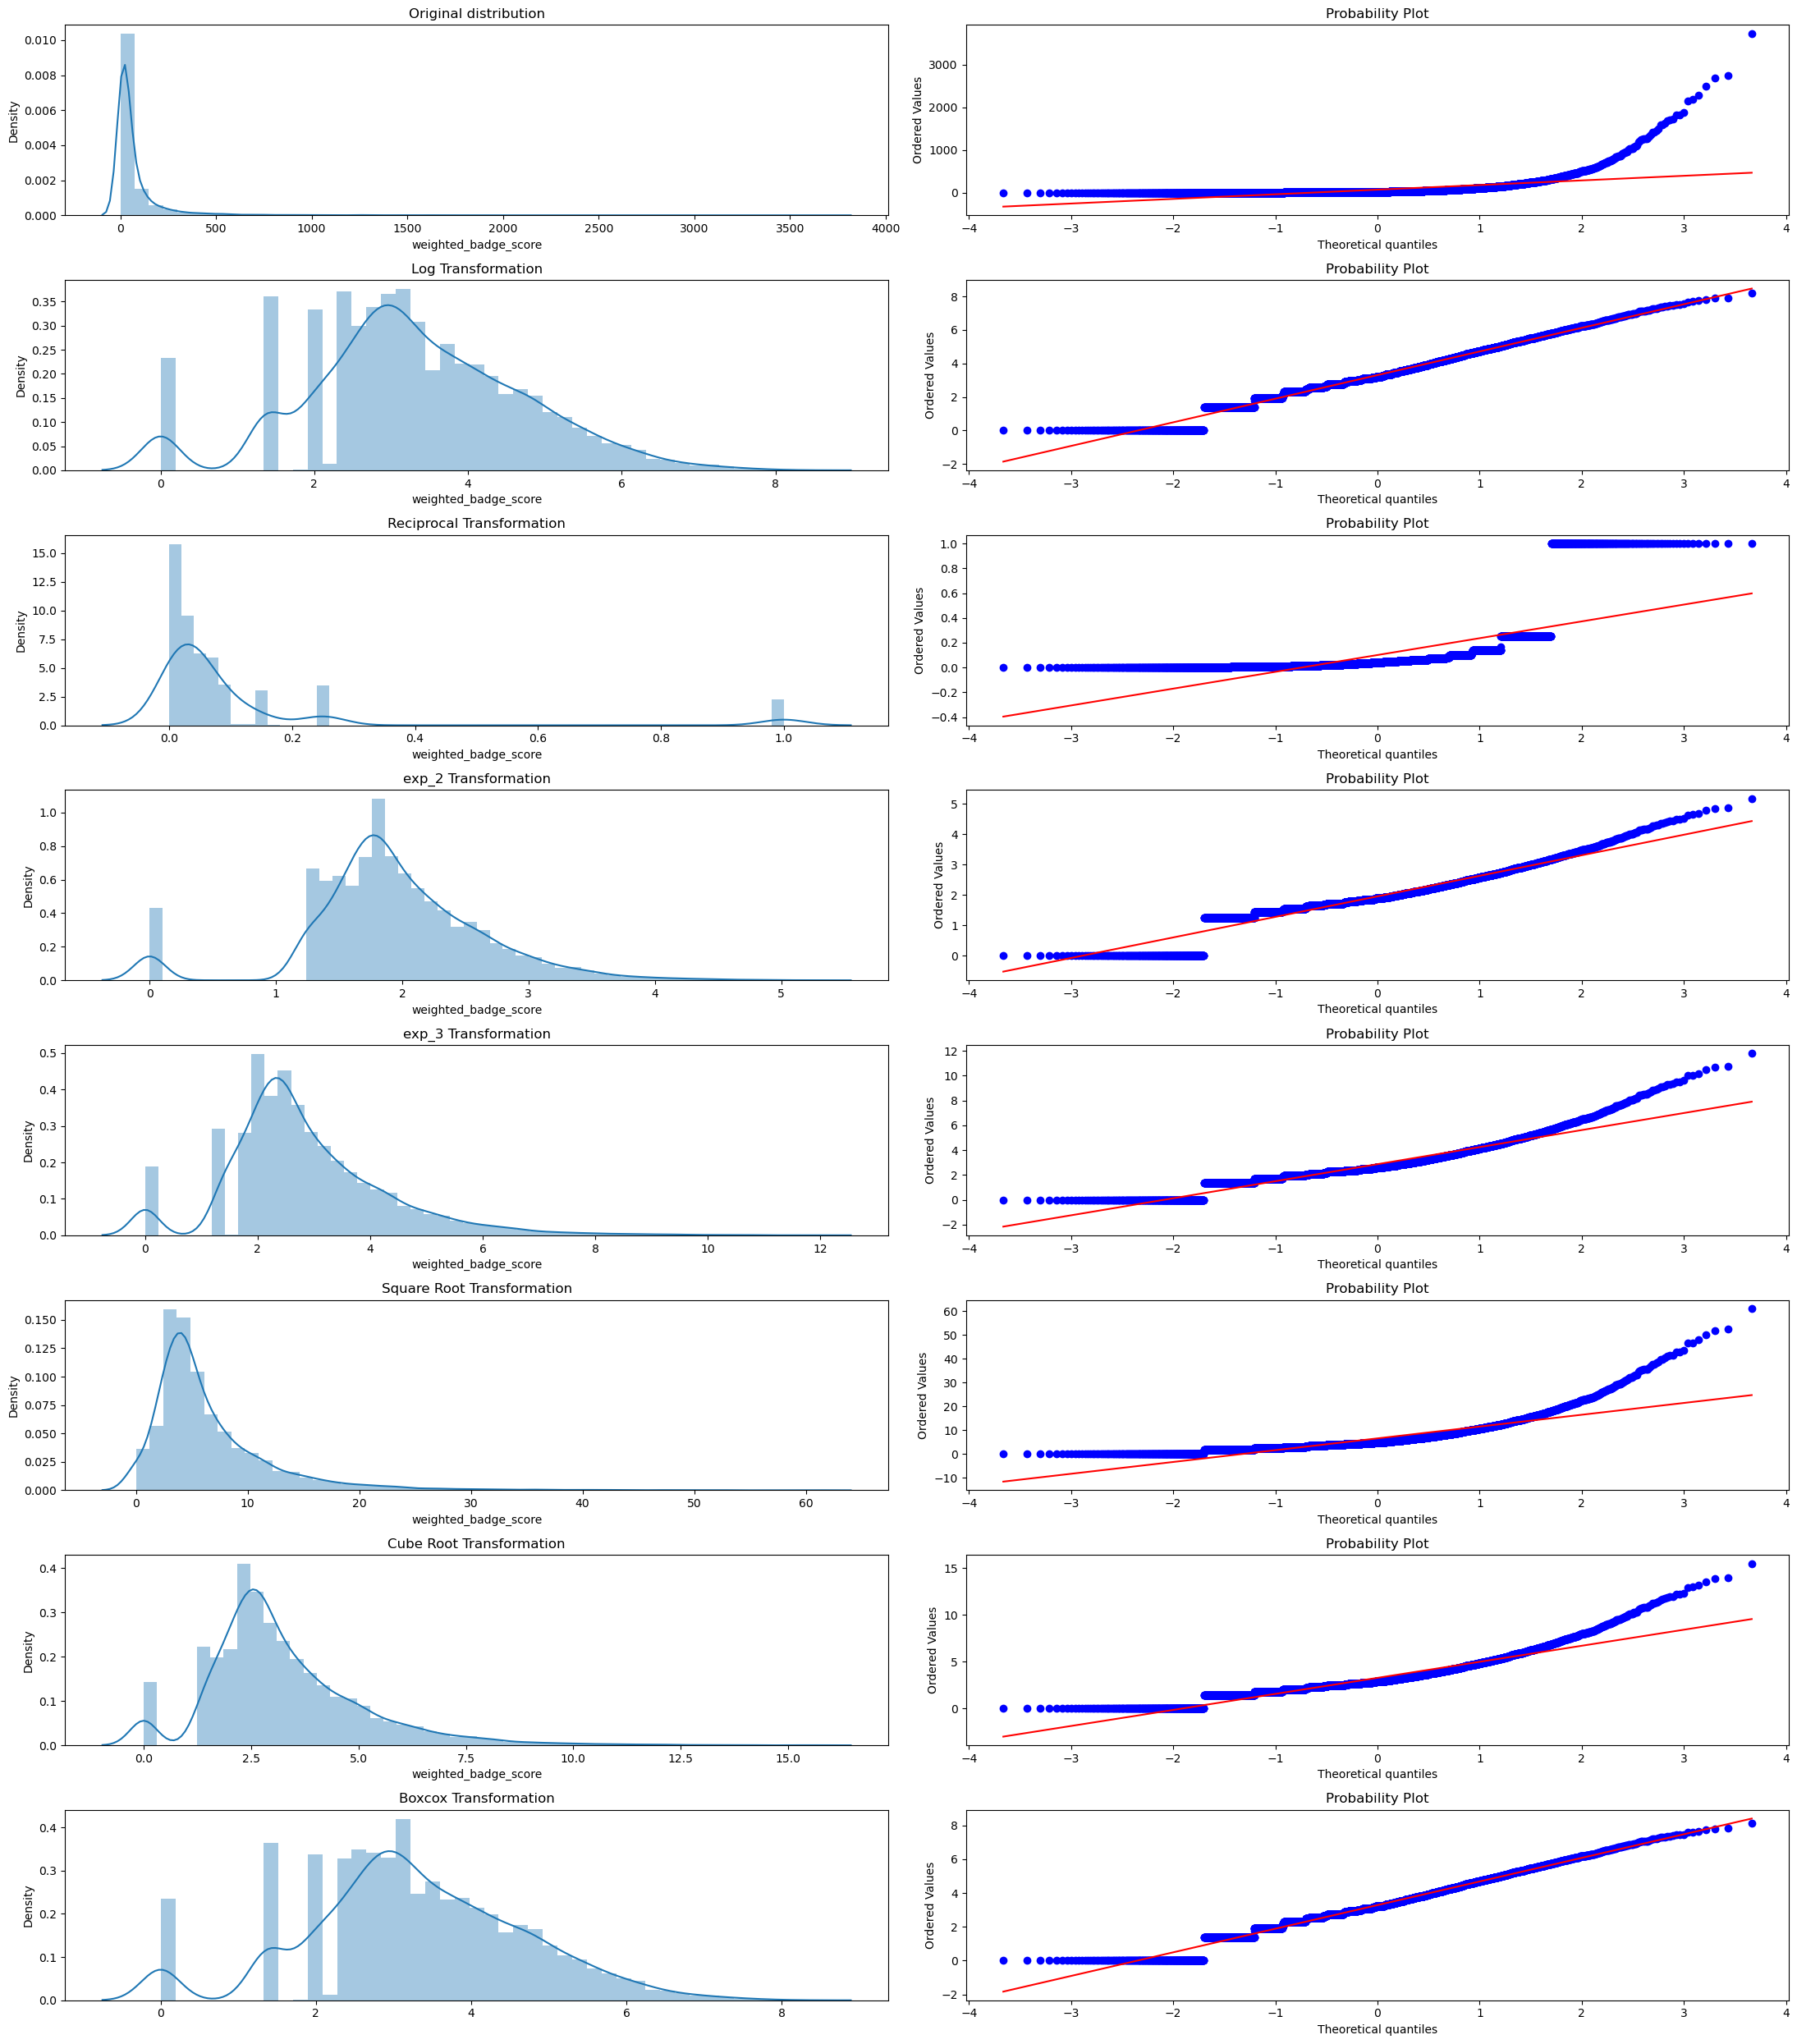

QA_RATIO 

       Transformation      Skew
               Actual 20.692734
                  Log  3.168880
           Reciprocal -1.187902
Exponential power 0.2  0.394795
Exponential power 0.3  1.749752
          Square Root  6.457525
            Cube Root  2.349343
               Boxcox  0.673770

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.3947949266892335


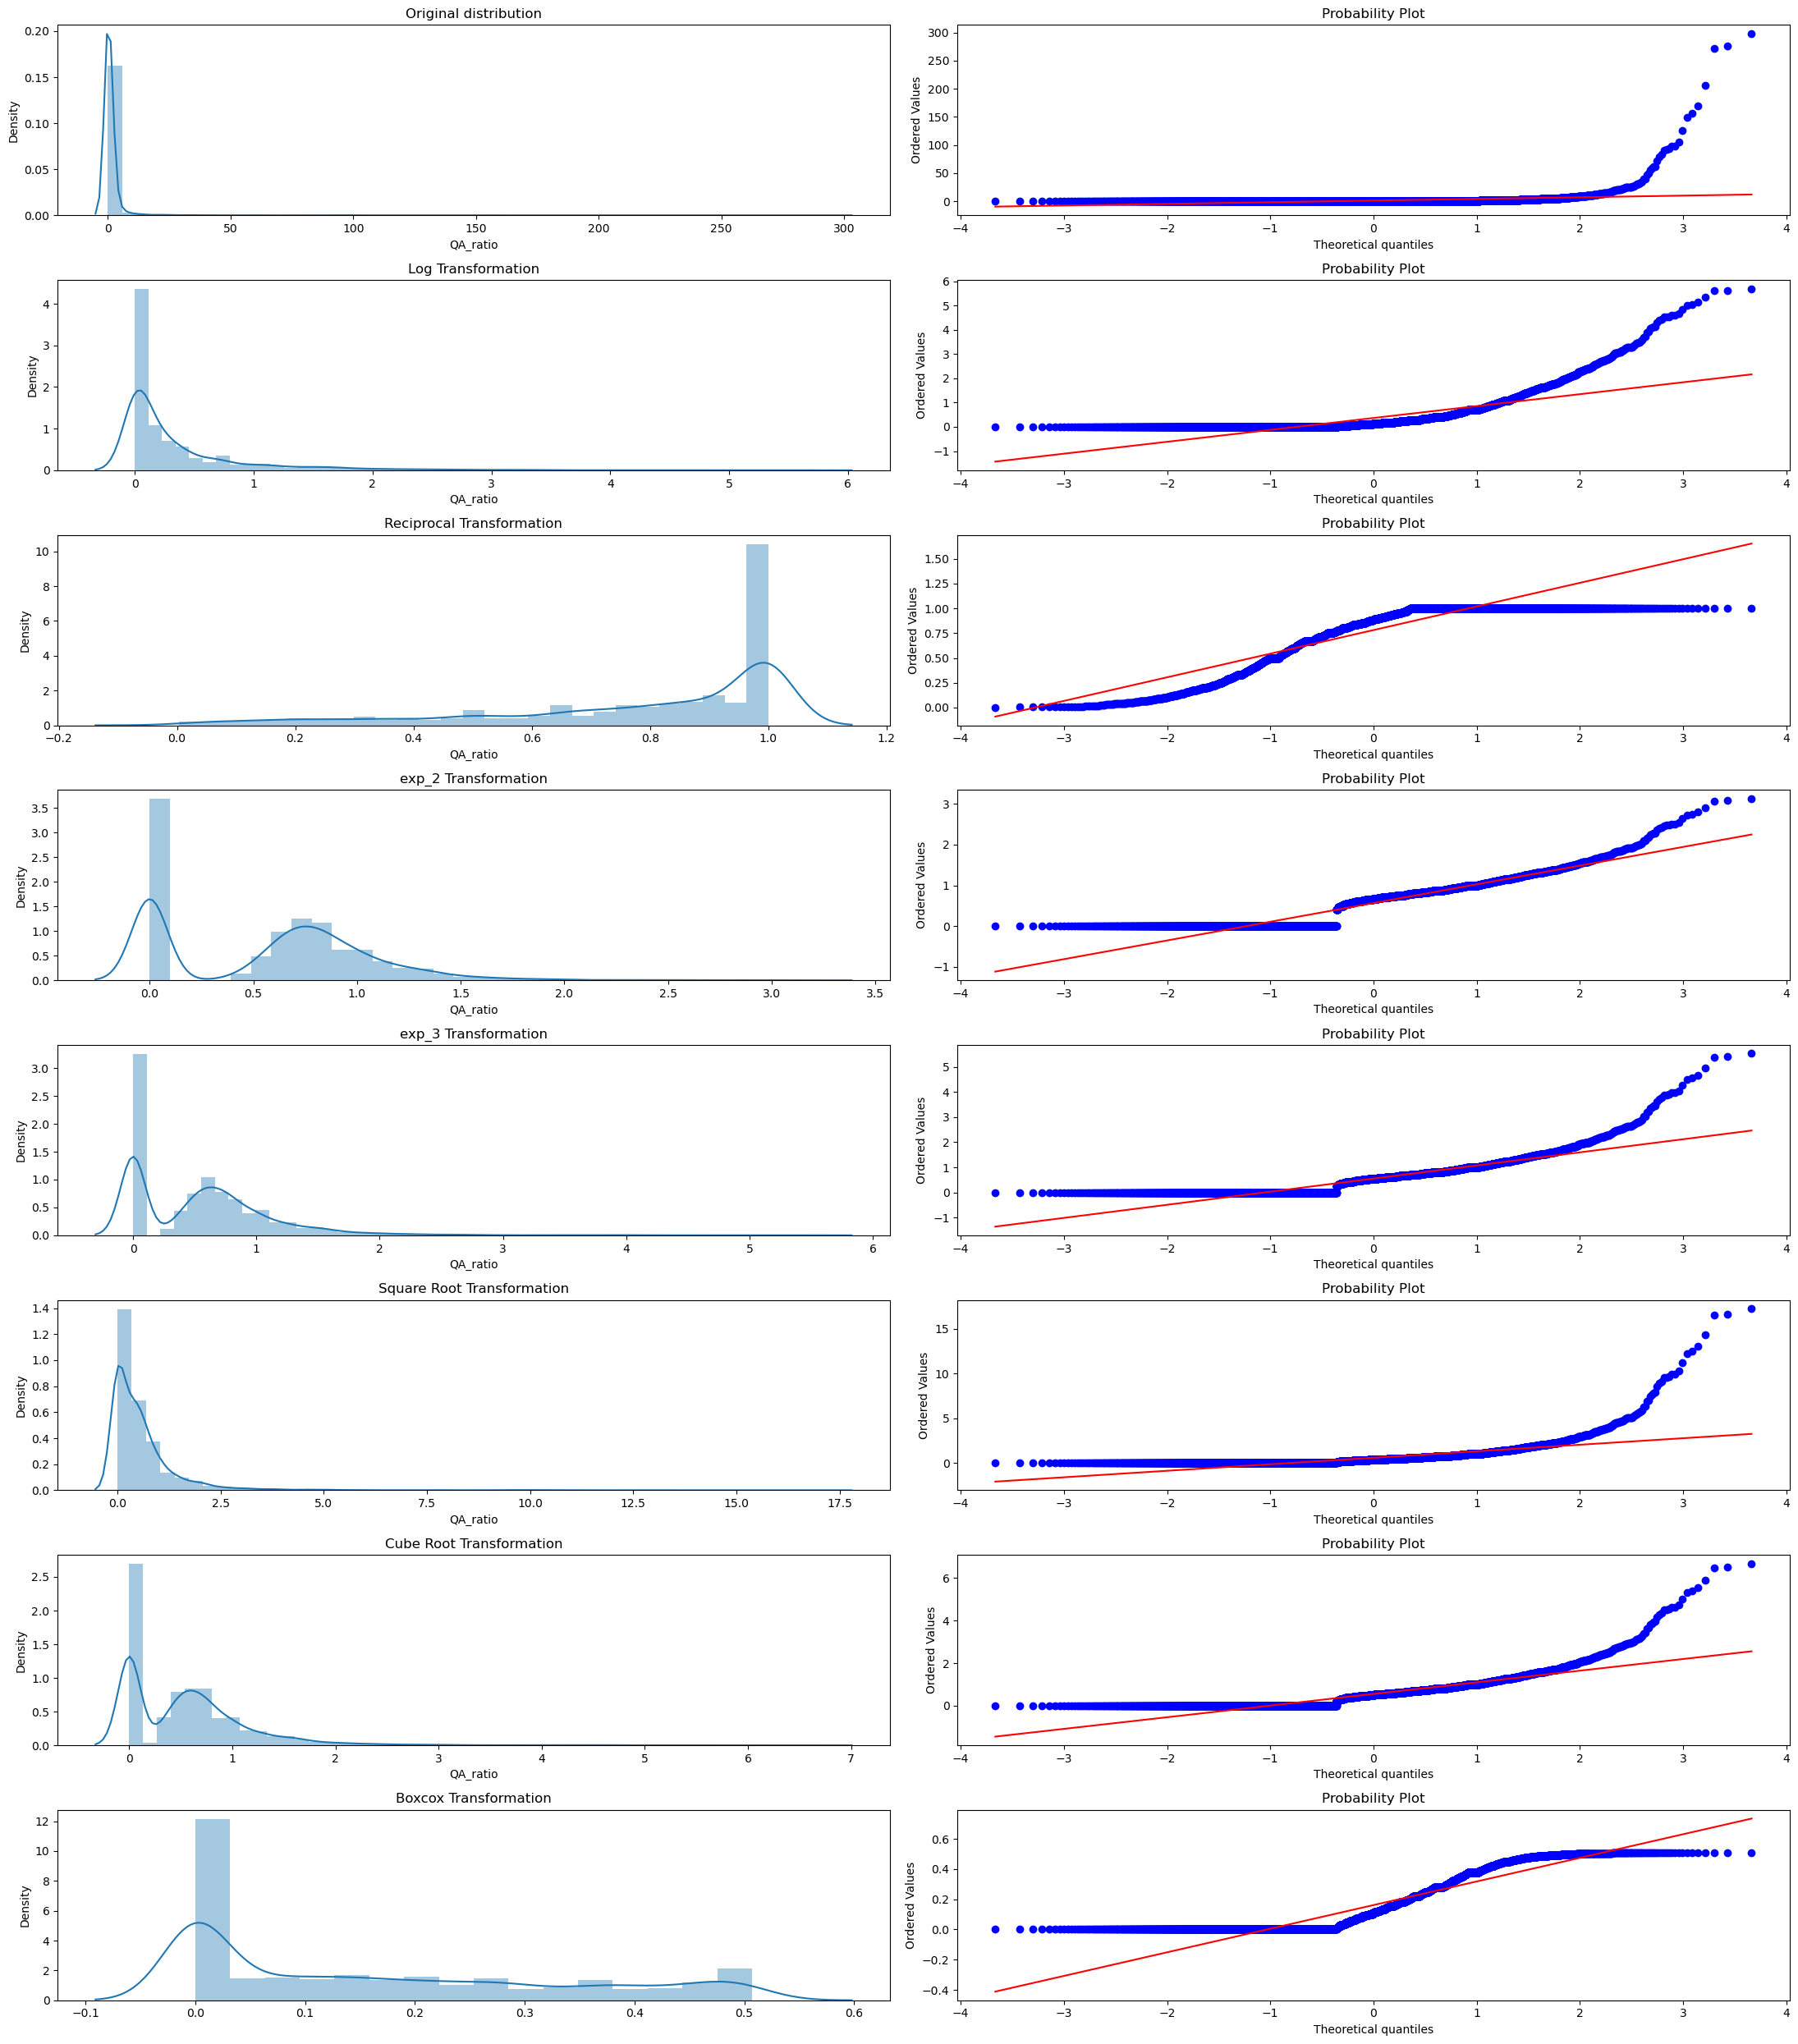

In [14]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [16]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
df_train['answers_st'],ans = st.boxcox(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],helpf = st.boxcox(df_train['helpful_tags']+1)
df_train['votes_cast_st'],vote = st.boxcox(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [17]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [20]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  13.921525
1                        reached_st  10.711271
2                      questions_st   6.682333
3                        answers_st  12.576189
4                   posts_edited_st   2.629884
5                   helpful_tags_st   2.100703
6                     votes_cast_st   5.564152
7           weighted_badge_score_st  10.383155
8                       QA_ratio_st   6.475030
9         member_since_in_months_st   2.807380
10  total_requirements_satisfied_st   1.084556

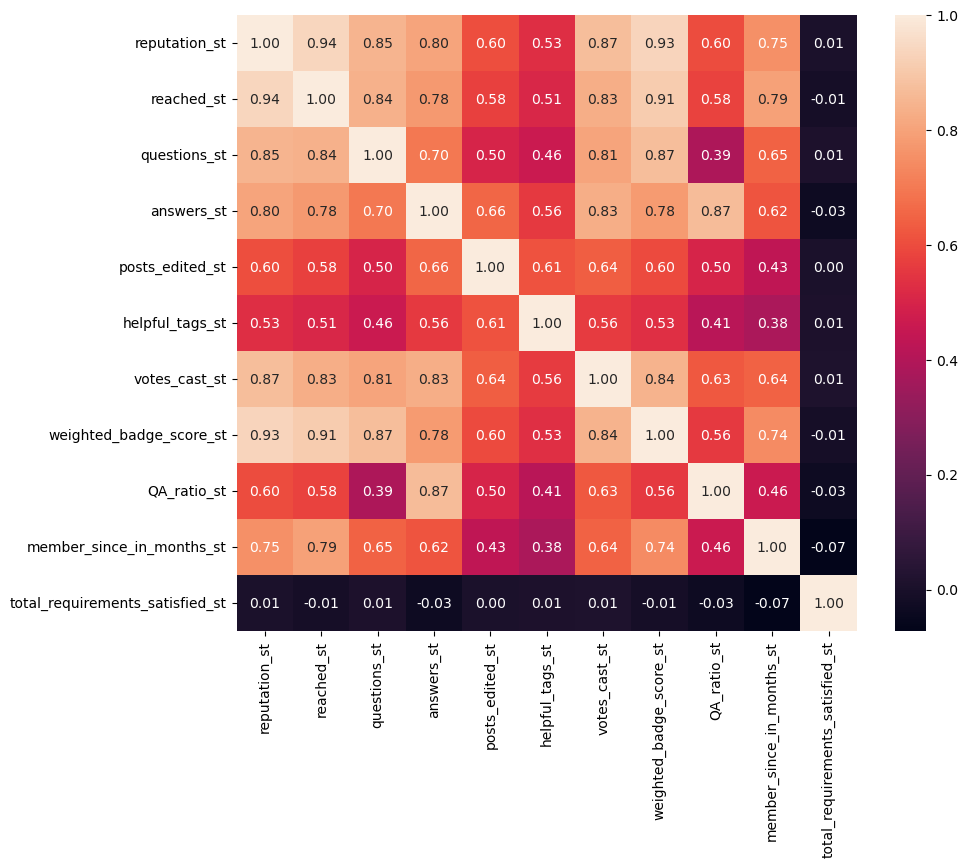

In [21]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

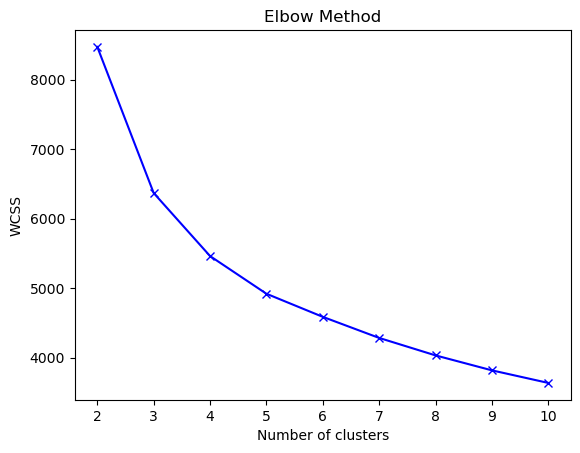

In [25]:
kmodel = df_train.copy()
wcss = []
results = []

for i in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  # X is your data
    wcss.append(kmeans.inertia_)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(2, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [26]:
elbow_data

Number of Clusters         WCSS
0                   2  8471.707176
1                   3  6368.075082
2                   4  5460.761212
3                   5  4918.097902
4                   6  4585.426236
5                   7  4282.073941
6                   8  4030.674661
7                   9  3815.382418
8                  10  3634.255959

## Training the model

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [28]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0             80.31     9521.72       7.45     0.83          0.02   
1          12875.66  2353487.46     140.15   160.25         74.76   
2            675.26   109465.98      27.58    12.58          2.10   
3              6.12      268.37       1.92     0.12          0.00   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.04        6.77                   61.83   
1               44.76     1084.52                  138.06   
2                1.67      113.57                   97.62   
3                0.00        0.07                   18.69   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       16.48      0.23                          2.16  
1                      263.35      3.66                          2.15  
2                       44.08      1.60                          2.16  
3                        4.45      0.09                          2.16

In [48]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0              4.81      205.59       1.77     0.10          0.00   
1           9278.58  1900641.56     117.61   120.70         51.77   
2             96.81    10086.75       8.84     0.49          0.01   
3            533.72    72491.45      29.35     8.77          1.12   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.00        0.01                   14.75   
1               38.07      880.98                  120.19   
2                0.03        7.41                   50.55   
3                1.10      105.01                   78.17   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                        3.87      0.07                          3.08  
1                      213.61      3.47                          3.09  
2                       16.22      0.16                          3.10  
3                       38.63      1.26                          3.10

In [29]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        2              1646
1        0              1597
2        1              1196
3        3              1161

In [49]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        3               465
1        2               429
2        1               332
3        0               318

## Visualizing Clusters

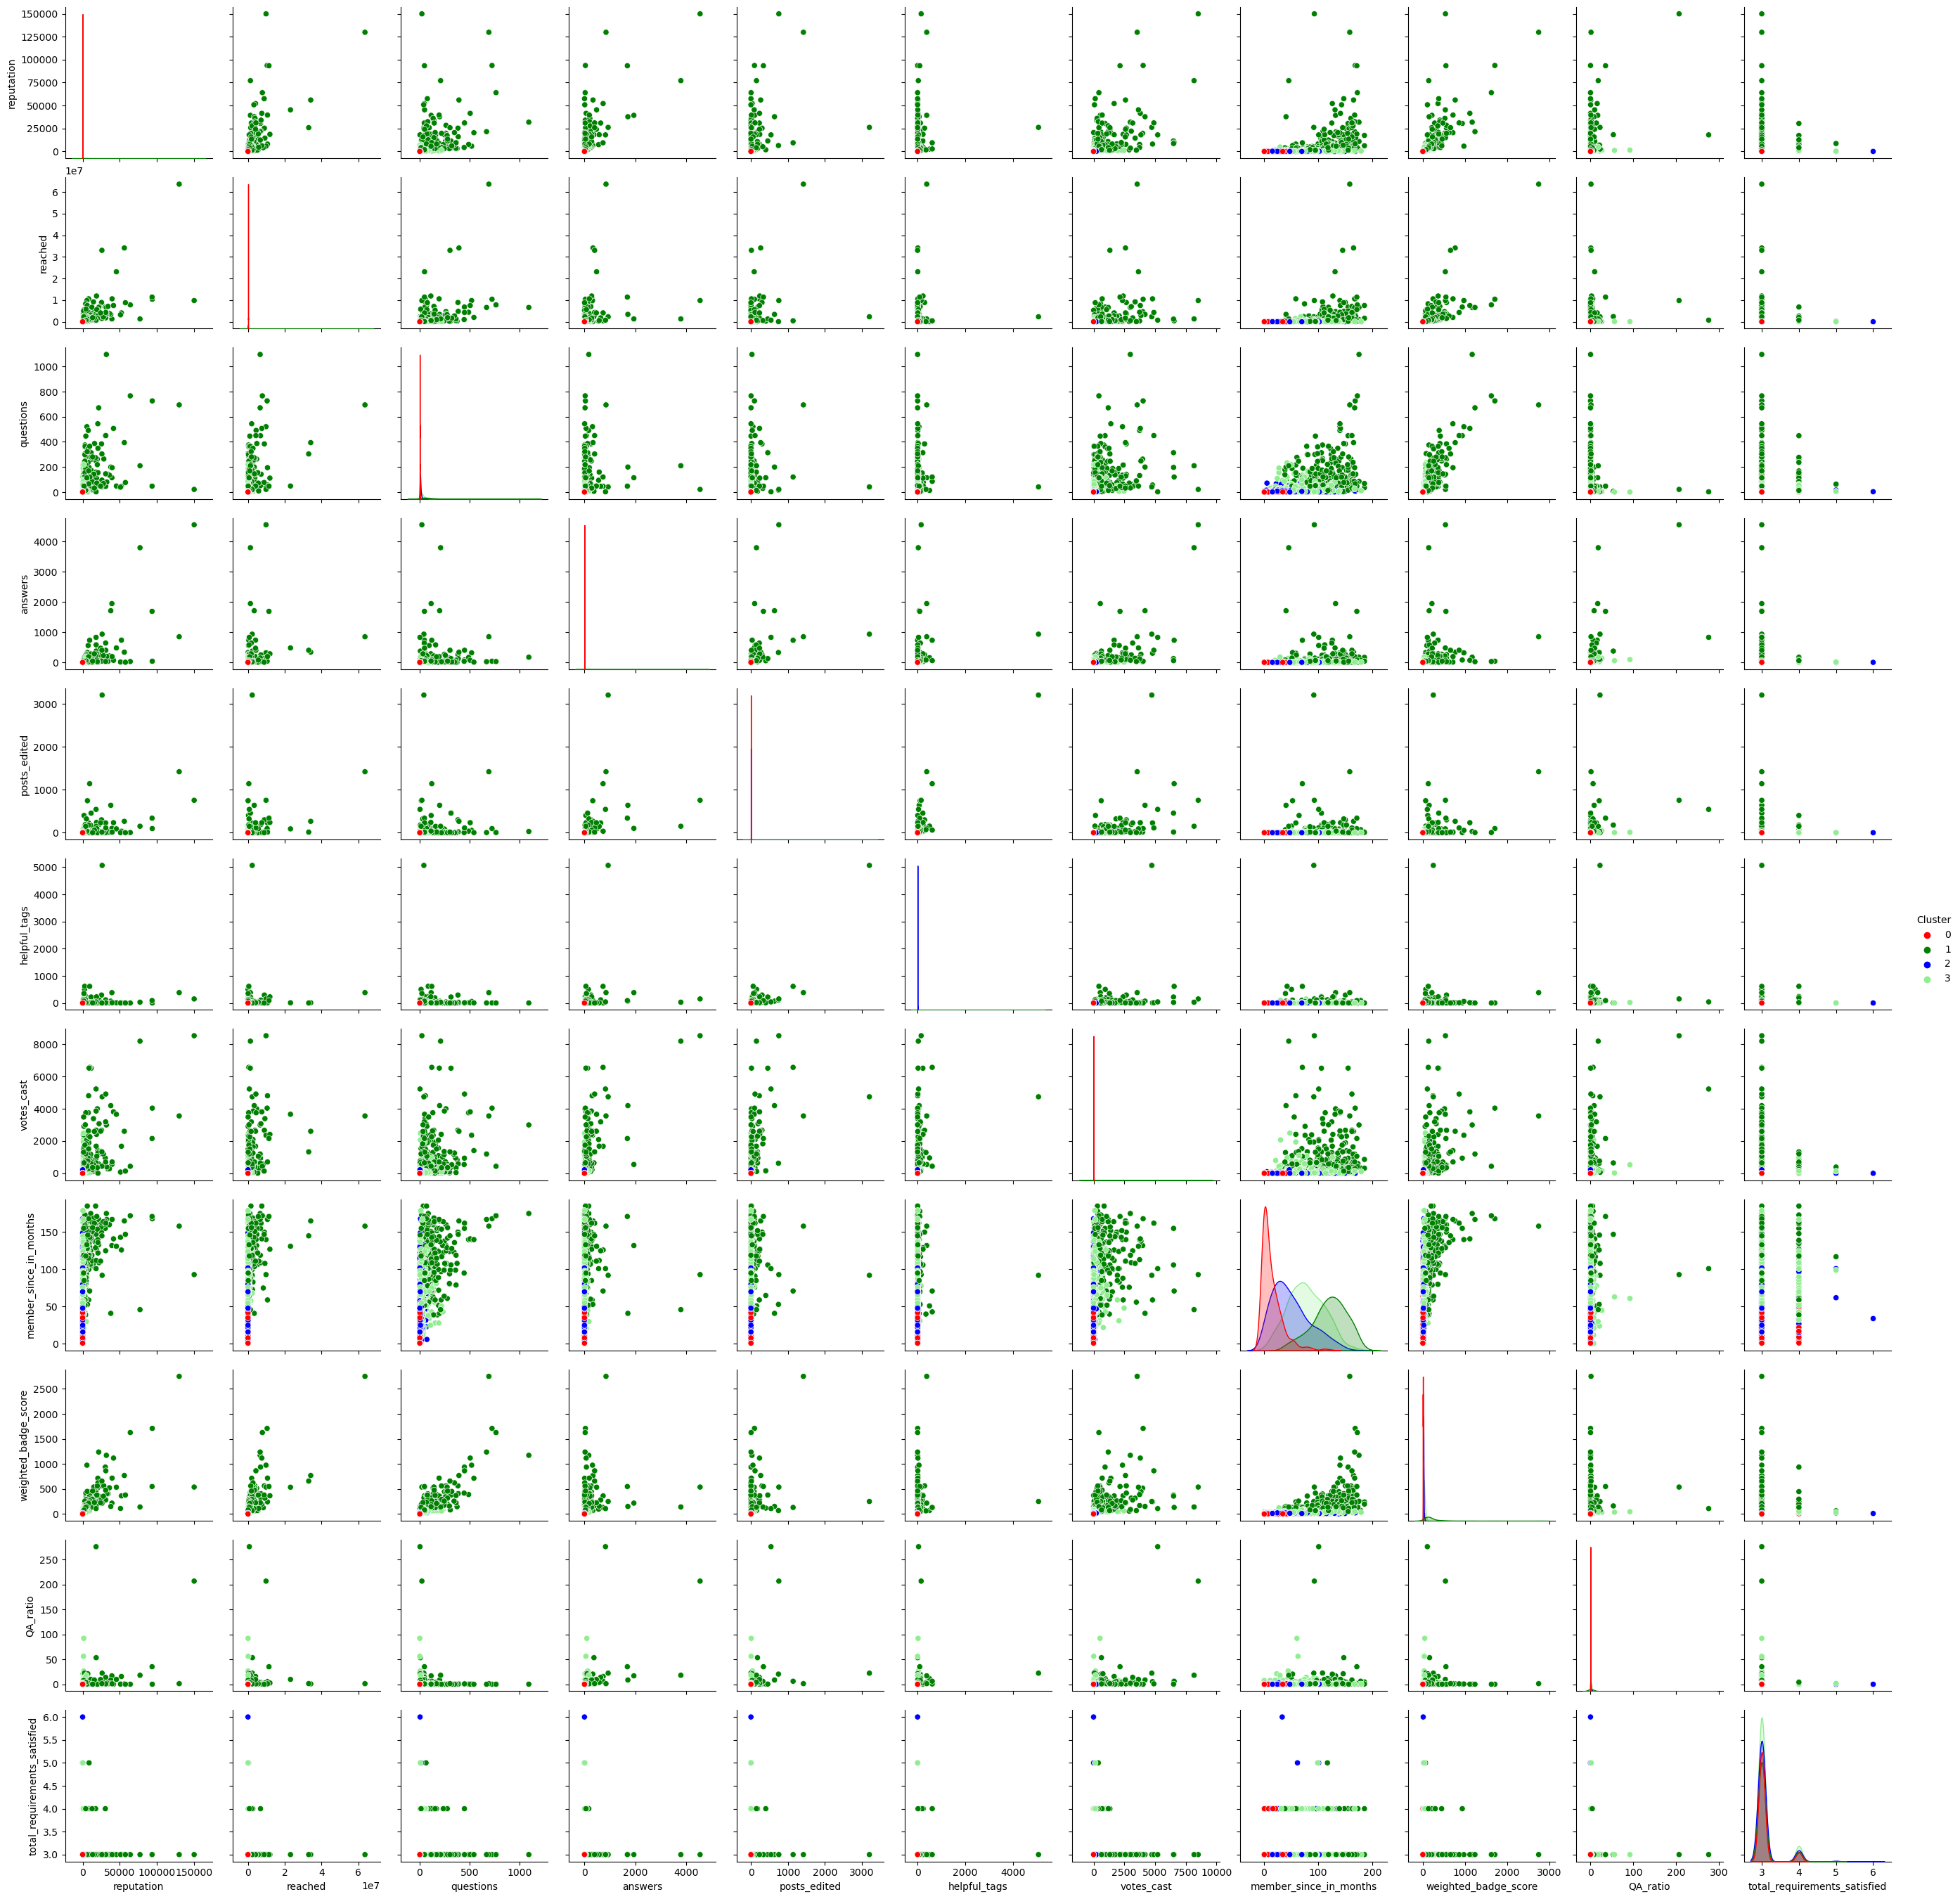

In [55]:
import seaborn as sns
palette = {0: "red", 1: "green", 2: "blue", 3: "lightgreen"} 
sns.pairplot(kmodel_inference, hue='Cluster', palette = palette)
plt.show()

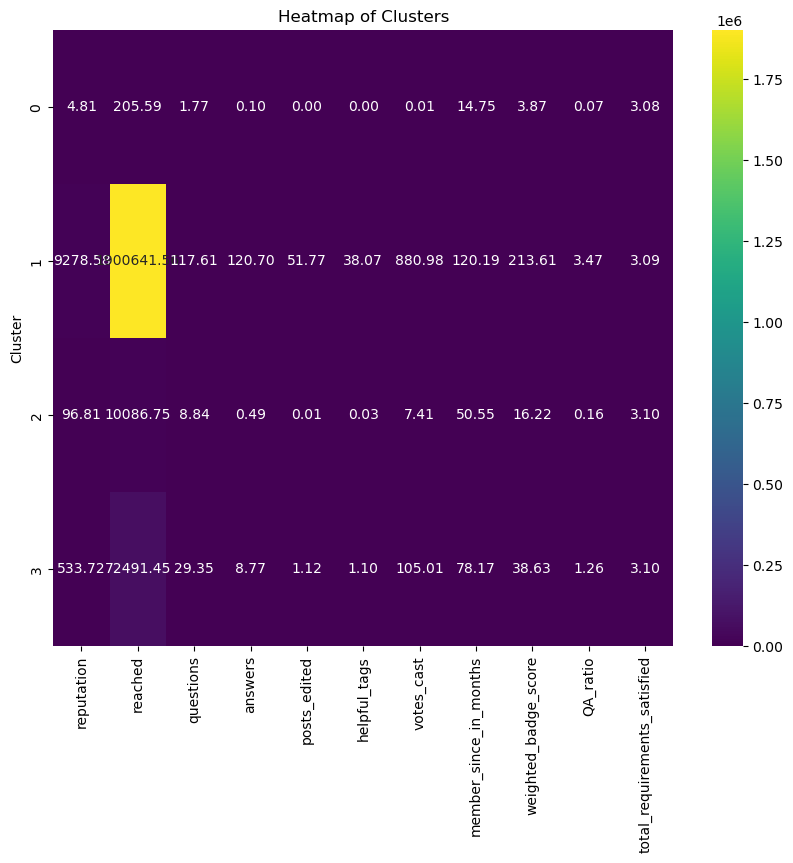

In [52]:
corr_matrix = kmodel_inference.groupby('Cluster').mean().round(2)
corr_matrix.sort_values(by='Cluster',inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap = 'viridis')
plt.title('Heatmap of Clusters')
plt.show()

## TESTING

In [30]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['Programming_Language_Flag'] = np.where(df_test['tags'].str.contains('python|r'),1,0)
df_test['Data_Analysis_Flag'] = np.where(df_test['tags'].str.contains('pandas|exploratory-data-analysis|dataframe|data-analysis'),1,0)
df_test['DBMS_Flag'] = np.where(df_test['tags'].str.contains('sql'),1,0)
df_test['Visualization_Flag'] = np.where(df_test['tags'].str.contains('tableau|powerbi|power-bi|seaborn|matplotlib|visualization|ggplot'),1,0)
df_test['Modeling_Flag'] = np.where(df_test['tags'].str.contains('scikit-learn|statsmodels|machine-learning|regression'),1,0)
df_test['Data_Analysis_Flag'] = np.where(df_test['Modeling_Flag']==1, 1, df_test['Data_Analysis_Flag'])
df_test['Statistics_Flag'] = np.where(df_test['tags'].str.contains('statistics|scipy|anova|hypothesis|statistical|anova'),1,0)
df_test['total_requirements_satisfied'] = df_test['Programming_Language_Flag']+df_test['DBMS_Flag']+df_test['Visualization_Flag']+df_test['Modeling_Flag']+df_test['Data_Analysis_Flag']+ df_test['Statistics_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[df_test['total_requirements_satisfied']>=2]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'],ans = st.boxcox(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],helpf = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'],vote = st.boxcox(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [31]:
testing_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0            104.26    14618.12       8.10     0.95          0.05   
1          14366.32  2612508.29     122.82   168.34        687.08   
2            720.93   124613.09      27.40    12.39          2.69   
3              6.20      280.28       2.05     0.14          0.00   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.03        8.21                   61.17   
1               85.03     1456.46                  140.33   
2                1.67       93.74                   98.84   
3                0.01        0.07                   17.98   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                       16.85      0.32                          2.16  
1                      259.89      5.20                          2.14  
2                       44.51      1.40                          2.13  
3                        4.72      0.10                          2.19

In [32]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        0               484
1        2               473
2        1               362
3        3               345

## Validation

In [34]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.25757160009526175


In [35]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'data-scientist-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/data-scientist-model.pkl
